In [1]:
import cudf
import dask_cudf

base = None
def setup():
    from cluster import DistributedCluster
    cluster = DistributedCluster()
    cluster.start()
    from base_dask_cudf import BaseDfBench
    base = BaseDfBench("DASK_CUDF")
    base.load_dataset('parquet')
    return base

# CLUSTER

In [2]:
from cluster import DistributedCluster

In [3]:
cluster = DistributedCluster()

In [4]:
cluster.start()

In [5]:
cluster.client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 187.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40631,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 187.40 GiB
Comm: tcp://127.0.0.1:39351,Total threads: 1
Dashboard: http://127.0.0.1:41911/status,Memory: 187.40 GiB
Nanny: tcp://127.0.0.1:42101,


In [6]:
cluster.shutdown()

In [7]:
cluster.start("DASK")
cluster.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 187.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42113,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 187.40 GiB
Comm: tcp://127.0.0.1:35187,Total threads: 4
Dashboard: http://127.0.0.1:40535/status,Memory: 31.23 GiB
Nanny: tcp://127.0.0.1:35367,


# DATASET

In [1]:
from base_dask_cudf import BaseDfBench
import cudf
import dask_cudf

In [2]:
base = BaseDfBench("DASK_CUDF")

# base.load_dataset('parquet', path='data/mod_parquet')
base.load_dataset('parquet')

df = base.get_df()
columns = base.get_columns()
base.npartitions()

57

# Dask-cuDF problems (for reference)

## Dask-cuDF limits

### string --> datime problems

BaseDfBenchErrore che restituisce:
"TypeError: Implicit conversion to a host NumPy array via __array__ is not allowed, To explicitly construct a GPU matrix, consider using .to_cupy()
To explicitly construct a host matrix, consider using .to_numpy()."

In [5]:
base["gas_start_date"].head()

0    25 Novembre 2019
1    31 Dicembre 2020
2    31 Dicembre 2020
3    31 Dicembre 2020
4    31 Dicembre 2020
Name: gas_start_date, dtype: object

In [24]:
#CONVERSIONE COLONNE SU DASK_CUDF 
mesi = {
    'gennaio': '01',
    'febbraio': '02',
    'marzo' : '03',
    'aprile': '04',
    'maggio': '05',
    'giugno': '06',
    'luglio': '07',
    'agosto': '08',
    'settembre': '09',
    'ottobre': '10',
    'novembre': '11',
    'dicembre': '12',
}
cols = {
    0:'day',
    1:'month',
    2:'year'
}
a = base.split('gas_start_date', 2)
a = a.rename(columns=cols)
a['month'] = a['month'].str.lower().map(mesi)
dd.to_datetime(a).head()

AttributeError: Can only use .str accessor with string values

### Some improvements

NaN problems during assignment ...

In [47]:
base = setup()

/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33635 instead
  f"Port {expected} is already in use.\n"
/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41085 instead
  f"Port {expected} is already in use.\n"


In [34]:
#base.df = base.df.reset_index(drop=True)

In [35]:
cols = {
    0:'day',
    1:'month',
    2:'year'
}

month = {
    'gennaio': '01',
    'febbraio': '02',
    'marzo' : '03',
    'aprile': '04',
    'maggio': '05',
    'giugno': '06',
    'luglio': '07',
    'agosto': '08',
    'settembre': '09',
    'ottobre': '10',
    'novembre': '11',
    'dicembre': '12',
}

tmp = base.df["gas_start_date"]#.head()
# tmp = tmp.str.replace(' ', '-')
# tmp = tmp.str.split("-", 2, expand=True)
tmp = tmp.str.split(" ", 2, expand=True)
tmp = tmp.rename(columns=cols)
tmp['month'] = tmp['month'].str.lower().map(month)
tmp['day'] = tmp['day'].str.zfill(2)

tmp = tmp['year'] + "-" + tmp['month'] + "-" + tmp["day"]

tmp = tmp.compute()

tmp = cudf.to_datetime(tmp, format="%Y-%m-%d")
tmp = dask_cudf.from_cudf(tmp, npartitions=base.df.npartitions)
#base.df["gas_start_date"] = tmp.reset_index(drop=True)
#tmp = tmp.reset_index(drop=True)
#tmp.index = base.df["gas_start_date"].index
#tmp.index = base.df["gas_start_date"].index
base["gas_start_date"] = tmp.reset_index(drop=True)
"""
"""

'\n'

### Working Dask-cuDF version

In [53]:
def myfunc(df):
    cols = {
        0:'day',
        1:'month',
        2:'year'
    }

    month = {
        'gennaio': '01',
        'febbraio': '02',
        'marzo' : '03',
        'aprile': '04',
        'maggio': '05',
        'giugno': '06',
        'luglio': '07',
        'agosto': '08',
        'settembre': '09',
        'ottobre': '10',
        'novembre': '11',
        'dicembre': '12',
    }

    tmp = df#.head()
    # tmp = tmp.str.replace(' ', '-')
    # tmp = tmp.str.split("-", 2, expand=True)
    tmp = tmp.str.split(" ", 2, expand=True)
    tmp = tmp.rename(columns=cols)
    tmp['month'] = tmp['month'].str.lower().map(month)
    tmp['day'] = tmp['day'].str.zfill(2)

    tmp = tmp['year'] + "-" + tmp['month'] + "-" + tmp["day"]

    tmp = cudf.to_datetime(tmp, format="%Y-%m-%d")

    return tmp
"""
"""

result = base["gas_start_date"].map_partitions(myfunc, meta='datetime64[ns]')

In [54]:
result.isna().sum().compute()

7871

In [55]:
base["gas_start_date"] = result

In [56]:
base.df["gas_start_date"].isna().sum().compute()

7871

In [42]:
tmp.reset_index(drop=True).isna().sum().compute()

7871

In [41]:
tmp.npartitions

57

In [9]:
tmp.shape[0].compute()

10497143

In [ ]:
dask_cudf.from_cudf(tmp, npartitions=base.npartitions()).compute()

In [11]:
base.df["gas_start_date"].isna().sum().compute()

2288953

In [43]:
len(tmp.reset_index(drop=True))

10497143

In [61]:
tmp.reset_index(drop=True).isna().sum().compute()

7871

In [44]:
len(base.df["gas_start_date"])

10497143

In [45]:
base.df["gas_start_date"].compute()

0         2019-11-25 00:00:00.000000000
1         2021-01-29 00:00:00.000000000
2         2021-01-26 00:00:00.000000000
3         2021-01-26 00:00:00.000000000
4         2021-03-19 00:00:00.000000000
                      ...              
542441                             <NA>
542442                             <NA>
542443                             <NA>
542444                             <NA>
542445                             <NA>
Name: gas_start_date, Length: 10497143, dtype: datetime64[ns]

In [66]:
tmp.compute()

0        2019-11-25
0        2021-01-29
0        2021-01-26
0        2021-01-26
0        2021-03-19
            ...    
557445   2021-03-25
557446   2021-03-25
557447   2021-03-25
557448   2021-03-25
557449   2021-03-25
Length: 10497143, dtype: datetime64[ns]

In [77]:
base.df.index.compute().unique()

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            557440, 557441, 557442, 557443, 557444, 557445, 557446, 557447,
            557448, 557449],
           dtype='int64', length=557450)

### From string to float ("1,22 kwh --> 1.22")

In [ ]:
#Ottenere unità di misura
misure = base.split('average_gas_bill_cost', 1)[1].value_counts().index.compute()[0]
#rimozione unità di misura
base.strip(['average_gas_bill_cost'], '€/smc')['average_gas_bill_cost']
#sostituzione della , con .
base.replace(['average_gas_bill_cost'], ',', '.', regex=True)['average_gas_bill_cost']

#### Le operazioni preliminari vanno a buon fine, qua si aprono più scenari (fallimentari)

questa soluzione è quella corretta su dask normale, utilizzando dask_cudf però genera un errore dovuto alla conversione implicita di un array in un numpy array, cosa non fattibile all'interno della GPU quindi consiglia di costruire esplicitamente una matrice tramite Cupy (Cuda Python) ma queste sono operazioni interne alla libreria

In [ ]:
dd.to_numeric(base.get_df()['average_gas_bill_cost'])
 

Qua da 2 diverse tipologie di errori: una dovuta ai metadati e l'altra alla presenza di valori non convertibili, anche togliedo tutti i valori nan con [~base['average_gas_bill_cost'].isna()] la situazione non cambia

In [ ]:
base.get_df()['average_gas_bill_cost'].map_partitions(cudf.to_numeric, 'raise')

# Pipeline

In [ ]:
''' 
+++++ UTILITY ATTRIBUTES +++++
    
    user_code --> String --> (Anonymized) code for the customer that owns this utility
    customer_code --> String --> Combined with user_code provides a unique identifier for the utility. Even this field is anonymized
    city --> String --> City where the utility is located
    address --> String --> (Anonymized) address of the utility location
'''

In [ ]:
''' 
+++++ CUSTOMER ATTRIBUTES +++++
    
    user_code --> String --> (Anonymized) code that identifies the customer
    nominative --> String --> (Anonymized) customer name
    sex --> String --> Sex of the customer. It could be ‘M’, ‘F’, ‘P’, with ‘P’ denoting that the customer is a commercial activity (VAT number)
    age --> Int --> Age of the customer, set to null for commercial activities (sex = ‘P’). Its value must be >= 18
'''

In [ ]:
''' 
+++++ INVOICE ATTRIBUTES +++++
    
    bill_id --> Int --> Invoice identifier
    F1_kWh --> Float --> kWh of electricity consumed in the F1 time slot
    F2_kWh --> Float --> kWh of electricity consumed in the F2 time slot
    F3_kWh --> Float --> kWh of electricity consumed in the F3 time slot 
    date --> Date --> Start date
    light_start_date --> Date --> Start date of electricity invoice
    light_end_date --> Date --> End date of electricity invoice
    tv --> Float --> Television fee to pay
    gas_amount --> Float --> Gas fee to pay
    gas_average_cost --> Float --> Average cost of gas
    light_average_cost --> Float --> Average cost of electricity
    emission_date --> Date --> Emission date
    supply_type --> String --> Supply type (‘light’, ‘gas’, ‘gas and light’)
    gas_start_date --> Date --> Start date of gas invoice
    gas_end_date --> Date --> End date of gas invoice
    extra_fees --> Float --> Extra fees to pay
    gas_consumption --> Float --> Consumed gas
    light_consumption --> Float --> Consumed electricity
    gas_offer --> Float --> Name of the subscribed gas plan (anonymized)
    light_offer_type --> String --> Kind of plan for the electricity (‘single zone’, ‘bizone’, etc.)
    light_offer --> String --> Name of the subscribed electricity plan (anonymized)
    total_amount --> Float --> gas_amount + light_amount + extra_fees
    howmuch_pay --> Float --> Overall amount to pay, computed as total_amount + tv
    light_amount --> Float --> Amount to pay for the electricity
    average_unit_light_cost --> Float --> Average cost for electricity
    average_light_bill_cost --> Float --> Average cost for the electricity invoice
    average_unit_gas_cost --> Float --> Average cost for gas
    average_gas_bill_cost --> Float --> Average cost for the gas invoice
    billing_frequency --> String --> Billing frequency (‘monthly’, ‘quarterly’, etc.)
    bill_type --> String --> Kind of invoice (False means a “standard bill”)
    gas_system_charges --> Float --> Extra gas fees
    light_system_charges --> Float --> Extra electricity fees
    gas_material_cost --> Float --> Costs for gas
    light_transport_cost --> Float --> Extra electricity fees
    gas_transport_cost --> Float --> Extra gas fees
    light_material_cost --> Float --> Costs for electricity
'''

In [ ]:
''' 
+++++ DATA INGESTION +++++
    • Read data from its source
    • Study how to deal with data that doesn’t fit in memory (!) --> Da chiede a Gagliardelli
    • Locate missing values
    • Locate outliers
    • Sort data
'''

# Loading Dataset

In [1]:
import dask_cudf as dc
import dask.dataframe as dd
import dask.array as da
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import cudf
import numpy as np
from base_dask_cudf import BaseDfBench
import pandas as pd

#import graphviz

In [2]:
base = BaseDfBench("DASK")
# base = BaseDfBench()

In [3]:
# READ DATA FROM ITS SOURCE
# --- remove _sample one day

# We can use bill_id as the index for our dataset --> meglio di no
# base.load_dataset('/data/invoices_sample.csv', 'csv', index_col='bill_id')

# Uncomment the line under this one to load the pre-converted dataset
base.load_dataset('parquet', path='data/mod_parquet')
# base.load_dataset('parquet')
df = base.get_df()
columns = base.get_columns()
base.npartitions()

57

In [4]:
# Dataset's rows
# I commented the real computation because it takes a lot of time
# dataset_rows = base.get_df().shape[0].compute()
dataset_rows = 10497143
dataset_rows

10497143

In [45]:
# No Null rows
base.df.dropna(how='all')

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,...,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost
0,0,0.0,0.0,0.0,CIPRESSA,C23B8FC235DF5479FB28D81E827A59B819BB0748,0298E5E66B5653CDAACADD156261A2A916A56C7E,F,81,63D286C61D20D76E9C9317BEB8644D5EE45134E4,...,NaN,5AE3987CBA311BCAADC6274D28A7FB14B13B53C3,None,False,-0.06,<NA>,0.06,<NA>,-0.2,<NA>
1,1,81.0,62.0,76.0,ROCCAVIVARA,CBE6B021F41D589269FBC724C131CBFC9905D950,FDAE2B1E0934BB76255A727CC9F3F00AA39982D9,M,38,8053C7982DE8A18746A8F9F0D1DC4B0C33CAC0FA,...,NaN,5F88D510670063B20E789E6453BC2F3FB0BB67F7,None,False,<NA>,9.15,<NA>,5.68,<NA>,23.13
2,2,0.0,0.0,0.0,VIDRACCO,BFAEB566B3BB78B9ABD4F86DB3A78BFD8489013B,FEBE7F29FB854C477AFA7073C70F0E6EA81C6B00,M,53,4F053D54B9F1B6FE565498E7FA726501FD8FDD18,...,NaN,D4B8928760E729127EB4EB532C86127325FBA468,None,False,1.24,<NA>,-10.13,<NA>,-7.13,<NA>
3,3,0.0,0.0,0.0,MEZZOLOMBARDO,CBD30C382C72ED4A3D9DC9D11C13C155930E7C66,9220A3E83BDCE622F70A1456C7898687FD3EDAC8,M,50,115C7D34A79C66AFCDB4EB65262595B197B0F861,...,1.08,BD4DEF66D7EF2D3D683D9C381D2359AD24B41D9C,None,False,-0.88,<NA>,23.68,<NA>,17.66,<NA>
4,4,0.0,0.0,0.0,PINETO,4D17C711CADED6C1E9BD459088B4B80F24575FE7,642C21354EF6017D13220517E2A25D4A0442D4C5,M,65,C7734B97A212004CEA25956D8FDFEF068CD2B8F6,...,0.86,C0622AFD22384A4B54CD1ACAF7D988B89853A5AC,None,False,14.71,<NA>,141.57,<NA>,63.59,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542441,2512812,0.0,0.0,0.0,CASALZUIGNO,FE1047ECA6069845A48B36ABAD2A725C545A3ACD,59801133A00E8156E2FCB182350344C222C625E9,M,66,CCC653F93977E0948C0E71592DC0B35D8088BF80,...,1.23,B90850838689F4530C6B2403ABF9D6A7DB4A6C18,bimester,False,-2.09,<NA>,41.72,<NA>,34.95,<NA>
542442,2512813,0.0,0.0,0.0,ACQUANEGRA CREMONESE,31432A91213A1877995BE91793761AB04AB2C1D9,ED3368875442BC333089F2EF36CEF71865954BCC,F,46,CEF01180CFC826BD1B1D940A77532A09A4E13761,...,1.29,6CCC81E05B7ED7401945CB8FB42126B242AB443C,bimester,False,-1.1,<NA>,41.64,<NA>,34.03,<NA>
542443,2512814,0.0,0.0,0.0,SAN LUPO,B3260B1FAEE19CB253D0B27B10CDCE0F40606AA4,959F1C15E6FD24DF29439A2B4683EC280BB95466,M,45,255D0B199EAAC6E72B483D38E4EA85C643109633,...,1.58,5DC1024A436D07BDF4C4853A752CF89775C3F295,bimester,False,-3.83,<NA>,30.81,<NA>,21.25,<NA>
542444,2512815,0.0,0.0,0.0,VERNATE,9AADECE289CFA1A60FAE6F30354B16DEEE1644A0,D3FD778C3F95AE2DAB5B9A1FE11FC14728D85164,M,64,A6E6C0A1A17CE15A4A822F516E5F6B1E8CD68B23,...,1.09,454279C1315FE7D78684138FB9998240B99D86DC,bimester,False,-0.22,<NA>,67.14,<NA>,27.61,<NA>


In [16]:
#verica di user_code+customer_code = PK utility
#PK customer = user_code
#PK invoice = bill_id
base.df.groupby(by=['user_code', 'customer_code'])['bill_id'].count().compute()

user_code                                 customer_code                           
00006B484AF40AAA281E0EB6CBFC24C0A8199713  F40D5C4B63C2EB173AE7EA30403D4FA9EEAD02D1    3
00007C8A923FD0298ED2543F04D17533CCB4AAA2  F48D3927FB4025B1FF5CE3A3DDE13CE948C6B1AF    2
000099877B93C34F2BA38AC7C59A4EE3BF28A89E  F4E34D59D28F32C1356DF301A6251CA75E0ECDE7    2
0000B5295F650B08A23F32EDDDE6422A52C52E49  B1AD8D50D84304308C69E59973ECC031767FA766    1
0000BDB9D89B996B5B9C731CE46FD91B6AC3667F  68E97A9483B7B8022011F79C252B2B6F77633882    5
                                                                                     ..
FEA81109269462AA6C4BAAC80D6EA5F0461B2751  6832D2AC36F045F19F905079A0A02A917838C738    1
FF0186066B0A5D5E85883E327F0A458CCCB1903C  454D3331A442C2B5566144DAC19BB1052DCF1202    1
FF06A66B75EB75D8AC6D5E5A04AD80951A0459FE  DBB85941ADE56FC9883B2650AFC9E09330FD8B5B    1
FF07EE3194E14E0E0485F153E442094E98511281  E1DF8A3590BCD5943DEEF8EEB31A49F53A9D44D6    1
FF4160E1D51F1A636AA01007803328998F688

## Load big Dataset (DEPRECATED)

In [ ]:
# STUDY HOW TO DEAL WITH DATA THAT DON'T FIT IN MEMORY (!)
!du -sh '/data/invoices_sample.csv'

In [ ]:
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
from dask.utils import parse_bytes
import cudf
import dask_cudf

In [ ]:
cluster = LocalCUDACluster(
    CUDA_VISIBLE_DEVICES="0",
    rmm_pool_size=parse_bytes("15GB"), # This GPU has 16GB of memory
    device_memory_limit=parse_bytes("10GB"),
)
client = Client(cluster)
client

In [ ]:
%%time
ddf = dask_cudf.read_csv("/data/invoices.csv", chunksize="1 GiB")
print(f"DF partitions: {ddf.npartitions}")
print(f"DF: {ddf}")

# UTILS

In [5]:
from bs4 import BeautifulSoup
import requests

url = [
"Comuni dell'Abruzzo",
"Comuni della Basilicata",
"Comuni della Calabria",
"Comuni della Campania",
"Comuni dell'Emilia-Romagna",
"Comuni del Friuli-Venezia Giulia",
"Comuni del Lazio",
"Comuni della Liguria",
"Comuni della Lombardia",
"Comuni delle Marche",
"Comuni del Molise",
"Comuni del Piemonte",
"Comuni della Puglia",
"Comuni della Sardegna",
"Comuni della Sicilia",
"Comuni della Toscana",
"Comuni del Trentino-Alto Adige",
"Comuni dell'Umbria",
"Comuni della Valle d'Aosta",
"Comuni del Veneto"
]

regioni = [
"Abruzzo",
"Basilicata",
"Calabria",
"Campania",
"Emilia-Romagna",
"Friuli-Venezia Giulia",
"Lazio",
"Liguria",
"Lombardia",
"Marche",
"Molise",
"Piemonte",
"Puglia",
"Sardegna",
"Sicilia",
"Toscana",
"Trentino-Alto Adige",
"Umbria",
"Valle d'Aosta",
"Veneto"
]

comuni_dict = {}
comuni = pd.DataFrame(columns=['Comune', 'Regione'])

for cerca, reg in zip(url,regioni):
    website_url = requests.get(f'https://it.wikipedia.org/wiki/{cerca}').text
    soup = BeautifulSoup(website_url)
    table = soup.find_all('table')
    for i in range(10):
        comuni_dict[reg] = pd.DataFrame(pd.read_html(str(table))[i])
        if comuni_dict[reg].shape[0] == 1 or ('Comune' not in comuni_dict[reg].columns):
            print('errore', reg)
            print(len(pd.read_html(str(table))))
        else:
            comuni = pd.concat([comuni, comuni_dict[reg].assign(Regione=reg)[['Comune', 'Regione']]], axis=0)
            break

errore Friuli-Venezia Giulia
3
errore Puglia
3
errore Sicilia
9
errore Sicilia
9
errore Toscana
3
errore Umbria
3


In [7]:
base['Region'] = base['city'].str.strip().replace(to_replace="'", value='', regex=True).map(comuni)
base['Region'].value_counts().compute()

Lombardia                3033515
Piemonte                 1568066
Veneto                    805897
Campania                  685279
Puglia                    520215
Lazio                     421200
Calabria                  396102
Sicilia                   395856
Sardegna                  359182
Liguria                   301223
Abruzzo                   301011
Molise                    295970
Toscana                   265084
Emilia-Romagna            245888
Trentino-Alto Adige       230245
Friuli-Venezia Giulia     192818
Marche                    176382
Umbria                    110703
Basilicata                 81783
Valle d'Aosta              38378
Name: Region, dtype: int64

In [7]:
# Substitute False with standard bill

base['bill_type'] = base['bill_type'].replace('False', 'standard bill')

In [8]:
# Switch inverted columns
base.rename_columns({
    'gas_start_date':'gas_end_date',
    'gas_end_date':'gas_start_date'
})

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,light_average_cost,emission_date,supply_type,gas_end_date,gas_start_date,extra_fees,gas_consumption,light_consumption,gas_offer,light_offer_type,light_offer,howmuch_pay,total_amount,light_amount,average_unit_light_cost,average_light_bill_cost,average_unit_gas_cost,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,Float64,Float64,Float64,object,string,string,object,int64,object,object,object,object,object,string,string,Float64,object,object,object,object,object,Float64,Float64,uint64,object,uint64,object,object,string,string,string,string,string,object,string,object,Float64,Float64,Float64,Float64,Float64,Float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
# Map billing frequency with real numbers
num = {
    'bimester': 2,
    'quarterly': 4,
    'monthly' : 1,
}
base['b_freq'] = base['billing_frequency'].map(num)

In [10]:
# Dobbiamo metterli in inglese? Si può fare con un map
ing = {
    'luce': 'light',
    'gas e luce': 'gas and light',
    'gas' : 'gas',
}
base['supply_type'] = base['supply_type'].map(ing)
# base['supply_type'].value_counts().compute()

In [11]:
# given a pattern retrive the columns names containing it (like 'gas' to retrive columns gas related) 
def get_col_by_pattern(pat):
    ret = []
    for c in base.get_columns():
        if pat in c.split('_'):
            ret += [c]
    return ret

In [12]:
# CONVERTING ALL THE STRING COLUMNS TO OBJECT COLUMN
# THIS BECAUSE STRING COLUMNS CAUSE A LOT OF ERRORS WHEN PROCESSED AS STRINGS
for k,v in base.get_columns_types().items():
    if v == 'string':
        base[k] = base[k].astype('object')
    elif v == 'Float64':
        base[k] = base[k].astype('float')

In [13]:
# data type structuring
mappone = {'bill_id': 'int64',
 'F1_kWh': 'float64',
 'F2_kWh': 'float64',
 'F3_kWh': 'float64',
 'city': 'object',
 'address': 'object',
 'nominative': 'object',
 'sex': 'object',
 'age': 'int64',
 'user_code': 'object',
 'date': 'datetime64[ns]',
 'light_start_date': 'datetime64[ns]',
 'light_end_date': 'datetime64[ns]',
 'tv': 'float64',
 'gas_amount': 'float64',
 'gas_average_cost': 'float64',
 'light_average_cost': 'float64',
 'emission_date': 'datetime64[ns]',
 'supply_type': 'object',
 'gas_start_date': 'datetime64[ns]',
 'gas_end_date': 'datetime64[ns]',
 'extra_fees': 'float64',
 'gas_consumption': 'float64',
 'light_consumption': 'float64',
 'gas_offer': 'float64',
 'light_offer_type': 'object',
 'light_offer': 'object',
 'howmuch_pay': 'float64',
 'total_amount': 'float64',
 'light_amount': 'float64',
 'average_unit_light_cost': 'float64',
 'average_light_bill_cost': 'float64',
 'average_unit_gas_cost': 'float64',
 'average_gas_bill_cost': 'float64',
 'customer_code': 'object',
 'billing_frequency': 'object',
 'bill_type': 'object',
 'gas_system_charges': 'float64',
 'light_system_charges': 'float64',
 'gas_material_cost': 'float64',
 'light_transport_cost': 'float64',
 'gas_transport_cost': 'float64',
 'light_material_cost': 'float64',
 'b_freq':'float64'
}

In [14]:
#Check sui tipi di dato attuali
type_dict = base.get_columns_types()
for k,v in type_dict.items():
    if v != mappone[k]:
        print(f'mismatch in {k} with values: {v}, {mappone[k]}')

mismatch in date with values: object, datetime64[ns]
mismatch in light_start_date with values: object, datetime64[ns]
mismatch in light_end_date with values: object, datetime64[ns]
mismatch in tv with values: object, float64
mismatch in gas_amount with values: object, float64
mismatch in gas_average_cost with values: object, float64
mismatch in emission_date with values: object, datetime64[ns]
mismatch in gas_end_date with values: object, datetime64[ns]
mismatch in gas_start_date with values: object, datetime64[ns]
mismatch in extra_fees with values: object, float64
mismatch in gas_offer with values: uint64, float64
mismatch in light_offer with values: uint64, object
mismatch in howmuch_pay with values: object, float64
mismatch in total_amount with values: object, float64
mismatch in light_amount with values: object, float64
mismatch in average_unit_light_cost with values: object, float64
mismatch in average_light_bill_cost with values: object, float64
mismatch in average_unit_gas_cost

In [26]:
# Trovare le colonne a seconda del tipo di dato
int_cols = base.col_type(find=['int'])
string_cols = base.col_type(find=['string']) #object
float_cols = base.col_type(find=['float'])
numeric_cols = base.col_type(find=['numeric'])
date_cols = base.col_type(find=['date'])

# Convert Columns

In [ ]:
# DONE gas_amount, howmuch_pay, total_amount, light_amount to float
# DONE gas_average_col, gas_offer, average_unit_light_cost, average_light_bill_cost, average_unit_gas_cost, average_gas_bill_cost deve essere float non int, basta un astype()
# light_offer è segnato come string perché dovrebbe essere un nome ma nel dataset è un int (what)
# il caso light_offer risolto: in teoria è str ma in pratica è stato anonimizzato, provo il cast to string

In [16]:
base['light_offer'] = base['light_offer'].astype(str)

In [17]:
len(base.col_type('string'))

28

### Date conversion

In [18]:
# CONVERSIONE COLONNE SU DASK_CUDF 
mesi = {
    'gennaio': '01',
    'febbraio': '02',
    'marzo' : '03',
    'aprile': '04',
    'maggio': '05',
    'giugno': '06',
    'luglio': '07',
    'agosto': '08',
    'settembre': '09',
    'ottobre': '10',
    'novembre': '11',
    'dicembre': '12',
}
cols = {
    0:'day',
    1:'month',
    2:'year'
}
#finding columns with 'date' keyword
date_cols = []
for c in df.columns:
    # print(base[c].dtype)
    if 'date' in c.split('_') and base[c].dtype != 'datetime64[ns]':
        date_cols.append(c)

print(f'columns to convert to date: {date_cols}')
#converting these columns
for c in date_cols:

    print(c , df[c].dtype)
    
    a = base.split(c, 2)
    a = a.rename(columns=cols)
    a['month'] = a['month'].str.lower().map(mesi)
    base.get_df()[c] = dd.to_datetime(a, format="%d/%m/%Y")
    # print(a.head())
    
    # df[c] = base.split(c, 2)
    
    # print(base[c].head())

columns to convert to date: ['date', 'light_start_date', 'light_end_date', 'emission_date', 'gas_start_date', 'gas_end_date']
date object
light_start_date object
light_end_date object
emission_date object
gas_start_date object
gas_end_date object


In [19]:
base.df

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,light_average_cost,emission_date,supply_type,gas_end_date,gas_start_date,extra_fees,gas_consumption,light_consumption,gas_offer,light_offer_type,light_offer,howmuch_pay,total_amount,light_amount,average_unit_light_cost,average_light_bill_cost,average_unit_gas_cost,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost,b_freq
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,object,object,object,object,int64,object,datetime64[ns],datetime64[ns],datetime64[ns],object,object,object,float64,datetime64[ns],object,datetime64[ns],datetime64[ns],object,float64,float64,uint64,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Removing measure unit from strings and converting them into numbers

In [20]:
# this line can be used to retrieve alle the columns with a number pattern inside them but is too resources consuming
# Due to the small number of columns We preferred to analize them one by one

# base['howmuch_pay'].str.contains('[0-9]+[.,][0-9]*', regex=True).count().compute()
# [0-9]+[.,][0-9]*

In [21]:
#finding string columns with number inside
to_numeric_cols = []
for c in df.columns:
    if ('average'  in c.split('_') or 'amount' in c.split('_')) and (base[c].dtype in ['object', 'str']):
        # print(base[c].dtype)
        to_numeric_cols.append(c)

# Added manually after column analysis 
to_numeric_cols.append('howmuch_pay')
to_numeric_cols.append('tv')
to_numeric_cols.append('extra_fees')
print(to_numeric_cols)

['gas_amount', 'gas_average_cost', 'total_amount', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'average_unit_gas_cost', 'average_gas_bill_cost', 'howmuch_pay', 'tv', 'extra_fees']


In [22]:
# Exctracting measure unit from the column
# Commented bc is time consuming
# base.split('average_gas_bill_cost', 1)[1].value_counts().index.compute()[0]

In [23]:
# Converting columns from string tu numeric
partitions = base.npartitions()
for c in to_numeric_cols:
    base[c] = base[c].str.extract(r'([0-9]+[,.][0-9]*)', flags=0, expand=False)
    # print(f'{c} measure: {measure}')
    base.replace([c], ',', '.', regex=True)
    base[c] = dd.to_numeric(base[c], errors='coerce', meta=('float'))
# base.get_df().head()['average_gas_bill_cost']

In [24]:
base.df

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,light_average_cost,emission_date,supply_type,gas_end_date,gas_start_date,extra_fees,gas_consumption,light_consumption,gas_offer,light_offer_type,light_offer,howmuch_pay,total_amount,light_amount,average_unit_light_cost,average_light_bill_cost,average_unit_gas_cost,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost,b_freq
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,object,object,object,object,int64,object,datetime64[ns],datetime64[ns],datetime64[ns],float64,float64,float64,float64,datetime64[ns],object,datetime64[ns],datetime64[ns],float64,float64,float64,uint64,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [27]:
# Strip all the columns in order to remove all the whitespaces 
base.strip(string_cols)

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,light_average_cost,emission_date,supply_type,gas_end_date,gas_start_date,extra_fees,gas_consumption,light_consumption,gas_offer,light_offer_type,light_offer,howmuch_pay,total_amount,light_amount,average_unit_light_cost,average_light_bill_cost,average_unit_gas_cost,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost,b_freq
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,object,object,object,object,int64,object,datetime64[ns],datetime64[ns],datetime64[ns],float64,float64,float64,float64,datetime64[ns],object,datetime64[ns],datetime64[ns],float64,float64,float64,uint64,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [41]:
base.df = base.df.persist()

In [42]:
base.df

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,light_average_cost,emission_date,supply_type,gas_end_date,gas_start_date,extra_fees,gas_consumption,light_consumption,gas_offer,light_offer_type,light_offer,howmuch_pay,total_amount,light_amount,average_unit_light_cost,average_light_bill_cost,average_unit_gas_cost,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost,b_freq,new_light_consumption
npartitions=57,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,float64,object,object,object,object,int64,object,datetime64[ns],datetime64[ns],datetime64[ns],float64,float64,float64,float64,datetime64[ns],object,datetime64[ns],datetime64[ns],float64,float64,float64,uint64,object,object,float64,float64,float64,float64,float64,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### Save the modified dataset

In [43]:
# Save the converted dataset
base.to_parquet('data/mod_parquet')

In [44]:
base.load_dataset('parquet', path='data/mod_parquet')
base.get_columns_types()

{'bill_id': 'int64',
 'F1_kWh': 'float64',
 'F2_kWh': 'float64',
 'F3_kWh': 'float64',
 'city': 'object',
 'address': 'object',
 'nominative': 'object',
 'sex': 'object',
 'age': 'int64',
 'user_code': 'object',
 'date': 'datetime64[ns]',
 'light_start_date': 'datetime64[ns]',
 'light_end_date': 'datetime64[ns]',
 'tv': 'float64',
 'gas_amount': 'float64',
 'gas_average_cost': 'float64',
 'light_average_cost': 'float64',
 'emission_date': 'datetime64[ns]',
 'supply_type': 'object',
 'gas_end_date': 'datetime64[ns]',
 'gas_start_date': 'datetime64[ns]',
 'extra_fees': 'float64',
 'gas_consumption': 'float64',
 'light_consumption': 'float64',
 'gas_offer': 'uint64',
 'light_offer_type': 'object',
 'light_offer': 'object',
 'howmuch_pay': 'float64',
 'total_amount': 'float64',
 'light_amount': 'float64',
 'average_unit_light_cost': 'float64',
 'average_light_bill_cost': 'float64',
 'average_unit_gas_cost': 'float64',
 'average_gas_bill_cost': 'float64',
 'customer_code': 'object',
 'billi

## Tentativi

In [ ]:
# Dovrebbe accorgersi di colonne con similarità > soglia
# TODO --> FUNZIONE DA RIFARE PERCHé USA I SET E QUINDI NON CONFRONTA RIGA-RIGA 
#          MA SET(ELEMENTI_COL1) CON SET(eLEMENTI_COL2)
def get_duplicate_col(df, soglia=0.9):
        """
        Return a list of duplicate columns, if exists.
        Duplicate columns are those which have same values for each row.
        """  
        cols = df.columns.values
        #return [(cols[i], cols[j]) for i in range(0, len(cols)) for j in range(i+1, len(cols)) if self.df[cols[i]].equals(self.df[cols[j]])]
        
        return [(cols[i], cols[j]) for i in range(0, len(cols)) for j in range(i+1, len(cols)) if len(set(cols[i]) & set(cols[j])) / float(len(set(cols[i]) | set(cols[j]))) > soglia ]

# 1. INGESTION & DISCOVERY

## Analysis

### Supply type analysis

In [5]:
base['supply_type'].value_counts().compute()

gas              5686288
light            3684510
gas and light    1126345
Name: supply_type, dtype: int64

In [37]:
light_related = ['F1_kWh', 'F2_kWh', 'F3_kWh', 'light_start_date', 'light_end_date', 'light_average_cost', 'light_consumption', 'light_offer_type', 'light_offer', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'light_system_charges', 'light_transport_cost', 'light_material_cost', 'bill_type', 'supply_type']

All the 'supply_type' == 'gas' have F1,F2,F3 == 0 as expected
also they all have light_consumption == NaN, we set them to 0

In [23]:
(base[base['supply_type'] == 'gas'][['F1_kWh', 'F2_kWh', 'F3_kWh', 'light_consumption']] == 0).sum().compute()

F1_kWh               5686288
F2_kWh               5686288
F3_kWh               5686288
light_consumption          0
dtype: int64

In [11]:
base[base['supply_type'] == 'gas'][['F1_kWh', 'F2_kWh', 'F3_kWh', 'light_consumption']].isna().sum().compute()

F1_kWh                     0
F2_kWh                     0
F3_kWh                     0
light_consumption    5686288
dtype: int64

In [32]:
base.df['light_consumption'] = base.df['light_consumption'].mask(base['supply_type'] == 'gas', 0)

In [38]:
base[base['supply_type'] == 'gas'][light_related].isna().sum().compute()

F1_kWh                        0
F2_kWh                        0
F3_kWh                        0
light_start_date           5068
light_end_date             5068
light_average_cost            0
light_consumption             0
light_offer_type              0
light_offer                   0
light_amount                  0
average_unit_light_cost       0
average_light_bill_cost       0
light_system_charges          0
light_transport_cost          0
light_material_cost           0
bill_type                     0
supply_type                   0
dtype: int64

Non solo light consumption è a nan ma anche altre colonne, quindi cambio anche loro

In [33]:
base.df[['light_consumption', 'light_average_cost', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'light_system_charges', 'light_transport_cost', 'light_material_cost']] = base.df[['light_consumption', 'light_average_cost', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'light_system_charges', 'light_transport_cost', 'light_material_cost']] = base.df[['light_consumption', 'light_average_cost', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'light_system_charges', 'light_transport_cost', 'light_material_cost']].mask(base['supply_type'] == 'gas', 0)

In [39]:
base[base['supply_type'] == 'gas and light'][light_related].isna().sum().compute()

F1_kWh                         0
F2_kWh                         0
F3_kWh                         0
light_start_date            1142
light_end_date              1142
light_average_cost         52550
light_consumption              0
light_offer_type               0
light_offer                    0
light_amount                 516
average_unit_light_cost    53666
average_light_bill_cost    52401
light_system_charges       32048
light_transport_cost       31996
light_material_cost        31971
bill_type                      0
supply_type                    0
dtype: int64

In [42]:
base[(base['supply_type'] == 'gas and light') & (base[['F1_kWh', 'F2_kWh', 'F3_kWh']].sum(axis=1)==0)][light_related].isna().sum().compute()

F1_kWh                         0
F2_kWh                         0
F3_kWh                         0
light_start_date            1142
light_end_date              1142
light_average_cost         39506
light_consumption              0
light_offer_type               0
light_offer                    0
light_amount                 516
average_unit_light_cost    39506
average_light_bill_cost    39506
light_system_charges       31982
light_transport_cost       31946
light_material_cost        31967
bill_type                      0
supply_type                    0
dtype: int64

In [13]:
base.df['light_consumption'].head()

0      0.0
1    219.0
2      0.0
3      0.0
4      0.0
Name: light_consumption, dtype: float64

All the 'supply_type' == 'light' have gas_consumption == NaN, we set it to 0 
(not only gas_consumption)

In [14]:
base['gas_consumption'].isna().sum().compute()

3686753

In [34]:
gas_related = ['gas_consumption', 'gas_transport_cost', 'gas_material_cost', 'gas_system_charges', 'average_gas_bill_cost', 'average_unit_gas_cost', 'gas_average_cost', 'gas_amount']

In [26]:
(base[base['supply_type'] == 'light'][gas_related].isna()).sum().compute()

gas_consumption          3684510
gas_transport_cost       3684510
gas_material_cost        3684510
gas_system_charges       3684510
average_gas_bill_cost    3684510
average_unit_gas_cost    3684510
gas_average_cost         3684510
gas_amount               3684510
dtype: int64

In [27]:
base[gas_related].isna().sum().compute()

gas_consumption          3686753
gas_transport_cost       3761775
gas_material_cost        3755162
gas_system_charges       3762487
average_gas_bill_cost    4285780
average_unit_gas_cost    4287486
gas_average_cost         4287486
gas_amount               3686754
dtype: int64

In [35]:
base[gas_related] = base[gas_related].mask(base['supply_type'] == 'light', 0)

In [29]:
base[gas_related].isna().sum().compute()

gas_consumption            2243
gas_transport_cost        77265
gas_material_cost         70652
gas_system_charges        77977
average_gas_bill_cost    601270
average_unit_gas_cost    602976
gas_average_cost         602976
gas_amount                 2244
dtype: int64

In [25]:
(base[base['supply_type'] == 'light'][gas_related].isna()).sum().compute()

gas_consumption          0.0
gas_transport_cost       0.0
gas_material_cost        0.0
gas_system_charges       0.0
average_gas_bill_cost    0.0
average_unit_gas_cost    0.0
gas_average_cost         0.0
gas_amount               0.0
dtype: float64

I rimanenti NaN sono in gas and light, possiamo ipotizzare che sia perché non hanno usato gas?

In [25]:
base[base['gas_consumption'].isna()][['gas_amount', 'gas_average_cost', 'gas_consumption', 'average_unit_gas_cost', 'average_gas_bill_cost', 'gas_system_charges', 'gas_material_cost', 'gas_transport_cost', 'supply_type', 'bill_type', 'light_consumption']].compute()

,gas_amount,gas_average_cost,gas_consumption,average_unit_gas_cost,average_gas_bill_cost,gas_system_charges,gas_material_cost,gas_transport_cost,supply_type,bill_type,light_consumption
1611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,42.0
1627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,582.0
1639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,83.0
1858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,149.0
2511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,438.0
...,...,...,...,...,...,...,...,...,...,...,...
535786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,409.0
535993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,317.0
536213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,421.0
536734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gas and light,False,1260.0


In [31]:
base[base['gas_consumption'].isna()]['supply_type'].value_counts().compute()

gas and light    2243
Name: supply_type, dtype: int64

In [27]:
base['gas_material_cost'].isna().sum().compute()

3755162

### Columns gas related

gas_amount, gas_average_cost, gas_start_date, gas_end_date, gas_consumption, gas_offer, average_unit_gas_cost, average_gas_bill_cost, gas_system_charges, gas_material_cost, gas_transport_cost

In [ ]:
base[['gas_amount', 'gas_average_cost', 'gas_start_date', 'gas_end_date', 'gas_consumption', 'gas_offer', 'average_unit_gas_cost', 'average_gas_bill_cost', 'gas_system_charges', 'gas_material_cost', 'gas_transport_cost']].tail()
# 'gas_average_cost' and 'average_unit_gas_cost' are equivalent

Let's verify if gas_consumption = gas_amount * gas_average_cost

In [16]:
base[(base['gas_amount'] == base['gas_consumption'] * base['gas_average_cost']) & (base['supply_type'] == 'gas')].shape[0].compute()

19

In [16]:
base['gas_offer'].value_counts().compute()

18446744073709551615    3686753
4894725755329590762     2362424
2533091950655969294      892439
4426041636325184338      574429
4255330384700204909      547743
                         ...   
427412161778972741            2
17440967613711628505          2
14667544299777454982          2
3902688171503331343           2
14804909859740436821          1
Name: gas_offer, Length: 123, dtype: int64

In [34]:
h, bins = da.histogram(base['gas_offer'].value_counts(), bins=np.array([0, 1, 10, 100, 1000, 10000, 100000, 1000000, 4000000]))

In [37]:
ranges = [f'{bins[i]} - {bins[i+1]}' for i in range(8)]

In [38]:
h = pd.Series(h.compute(), index=ranges)

<AxesSubplot:>

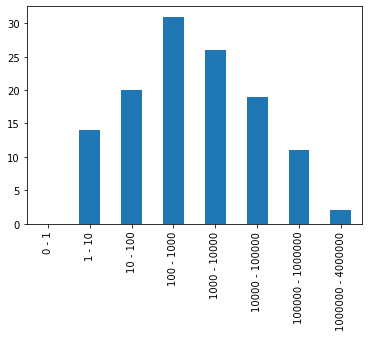

In [39]:
h.plot(kind='bar')

### Columns light related

F1_kWh, F2_kWh, F3_kWh, light_start_date, light_end_date, light_average_cost, light_consumption, light_offer_type, light_offer, light_amount, average_unit_light_cost, average_light_bill_cost, light_system_charges, light_transport_cost, light_material_cost

Riflessioni: 
light_consumption * average_light_bill_cost = light_amount, vero ma c'è un piccolissimo scarto che non li fa combaciare.

light_consumption * average_unit_light_cost = light_material_cost, soldi spesi dall'azienda per comprare l'energia anche qua c'è un piccolissimo scarto

light_amount - light_material_cost = guadagno dell'azienda, a cui bisogna togliere i costi di trasporto, light_system_charges

In [ ]:
base[['F1_kWh', 'F2_kWh', 'F3_kWh', 'light_start_date', 'light_end_date', 'light_average_cost', 'light_consumption', 'light_offer_type', 'light_offer', 'light_amount', 'average_unit_light_cost', 'average_light_bill_cost', 'light_system_charges', 'light_transport_cost', 'light_material_cost']].sample(frac=0.001).compute()

F1_kWh + F2_kWh + F3_kWh = light_consumption? 

In [26]:
base[(base['light_consumption'] == (base['F1_kWh'] + base['F2_kWh'] + base['F3_kWh']))].shape[0].compute()

10338688

In [116]:
157229 # don't match
10338688 # match

10338688

all the 529 light consumption remaining nan have f1,f2,f3 == 0 so we can set them to 0

In [27]:
base[base['light_consumption'].isna()].shape[0].compute()

529

In [28]:
(base[base['light_consumption'].isna()][['F1_kWh', 'F2_kWh', 'F3_kWh']] == 0).sum().compute()

F1_kWh    529.0
F2_kWh    529.0
F3_kWh    529.0
dtype: float64

In [36]:
base['light_consumption'] = base['light_consumption'].fillna(0)

Now let's see how many record doesn't match

In [19]:
base[(base['light_consumption'] == (base['F1_kWh'] + base['F2_kWh'] + base['F3_kWh']))].shape[0].compute()

10339217

In [20]:
base[(base['light_consumption'] != (base['F1_kWh'] + base['F2_kWh'] + base['F3_kWh']))].shape[0].compute()

157926

In [16]:
base[(base['light_consumption'] != (base['F1_kWh'] + base['F2_kWh'] + base['F3_kWh']))][light_related + ['city']].head()

,F1_kWh,F2_kWh,F3_kWh,light_start_date,light_end_date,light_average_cost,light_consumption,light_offer_type,light_offer,light_amount,average_unit_light_cost,average_light_bill_cost,light_system_charges,light_transport_cost,light_material_cost,bill_type,supply_type,city
31,165.0,168.0,187.0,2020-06-01,2020-11-30,<NA>,298.0,light single zone,2301382657258644717,18.59,NaN,NaN,12.47,16.31,-45.68,False,gas e luce,LOZZO DI CADORE
34,108.0,97.0,107.0,2020-06-01,2020-11-30,48.0,199.0,light single zone,13262346701792425167,54.21,0.13,0.27,8.32,15.48,25.48,False,gas e luce,FOSSALTA DI PIAVE
35,153.0,141.0,217.0,2020-02-10,2020-11-26,55.0,49.0,light single zone,5618533779135348807,5.37,0.06,0.11,2.05,-1.31,3.03,False,gas e luce,SANT'OMERO
38,125.0,128.0,135.0,2020-02-01,2020-03-31,<NA>,0.0,light single zone,1919282689015738106,17.96,NaN,NaN,0.0,0.0,-16.32,False,gas e luce,SAN GIOVANNI DI GERACE
44,1356.0,1053.0,1186.0,2019-08-01,2020-11-30,<NA>,-10.0,light single zone,5618533779135348807,2.41,NaN,NaN,-0.76,-0.07,-0.91,False,gas e luce,LIBRIZZI


In [41]:
base[(base['light_consumption'] != (base['F1_kWh'] + base['F2_kWh'] + base['F3_kWh']))]['supply_type'].value_counts().compute()

luce          112085
gas e luce     45144
Name: supply_type, dtype: int64

In [12]:
F_kWh = base[['F1_kWh', 'F2_kWh', 'F3_kWh']]
F_kWh = F_kWh.persist()

In [13]:
# row with all the values not null
F_kWh[~F_kWh.isna().any(axis=1)].shape[0].compute()

10496446

In [14]:
# rows with at least 1 value null
F_kWh[F_kWh.isna().any(axis=1)].shape[0].compute()

697

In [15]:
# row with all values null
F_kWh[F_kWh.isna().all(axis=1)].shape[0].compute()

85

In [15]:
all_na = base[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().all(axis=1)

85 su 10M di righe hanno sia F1 che F2 che F3 NaN ma il loro light consumption non lo è quindi sostituiamo i valori NaN con un valore medio del tot (F1,F2,F3 = light_consumption/3)
Non l'abbiamo implementato perché è molto difficile cambiare i valori in dask, magari guardiamoci più avanti

In [37]:
one_na = base[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().sum(axis=1) >= 1
one_na.sum().compute()

697

In [38]:
any_na = base[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().sum(axis=1) >= 1
base[any_na][['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']].compute()

,F1_kWh,F2_kWh,F3_kWh,light_consumption
9064,63.0,NaN,NaN,8.0
9618,-70.0,-54.0,NaN,-191.0
9783,-102.0,-76.0,NaN,-273.0
18807,27.0,20.0,NaN,39.0
26669,NaN,27.0,NaN,26.0
...,...,...,...,...
299548,56.0,43.0,NaN,153.0
316172,0.0,1.0,NaN,1.0
402530,NaN,NaN,NaN,12.0
414707,-44.0,-34.0,NaN,-120.0


In [39]:
any_na = base[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().sum(axis=1) >= 1

def mean_sub(df):
    any_na = df[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().sum(axis=1) >= 1

    denominatore = df[['F1_kWh', 'F2_kWh', 'F3_kWh']][any_na].isna().sum(axis=1)
    
    numeratore = df['light_consumption'][any_na] - df[['F1_kWh', 'F2_kWh', 'F3_kWh']][any_na].fillna(0).sum(axis=1)
 
    replace = df['F1_kWh'].isna()
    df['F1_kWh'][replace] = numeratore[replace] / denominatore[replace]
    
    replace = df['F2_kWh'].isna()
    df['F2_kWh'][replace] = numeratore[replace] / denominatore[replace]
    
    replace = df['F3_kWh'].isna()
    df['F3_kWh'][replace] = numeratore[replace] / denominatore[replace]

    return df

#base.df.map_partitions(mean_sub, meta=base.df)[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']][all_na].compute()
base[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']] = base.df.map_partitions(mean_sub, meta=base.df)[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']]#.sum()
base[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']][any_na][['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']].compute()

,F1_kWh,F2_kWh,F3_kWh,light_consumption
255015,31.0,24.0,30.0,85.0
261087,-90.0,-68.0,-85.0,-243.0
356523,-134.0,-102.0,-127.0,-363.0
392628,-42.0,-32.0,-40.0,-114.0
398081,-40.0,-29.0,-36.0,-105.0
...,...,...,...,...
160597,-44.0,-33.0,-41.0,-118.0
167973,55.0,41.0,8.0,104.0
255880,0.0,0.0,0.0,0.0
399408,40.5,63.0,40.5,144.0


In [31]:
def mean_sub(df):
    #all_na = (df['F1_kWh'].isna()) & (df['F2_kWh'].isna()) & (df['F3_kWh'].isna())
    all_na = df[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().all(axis=1)
    #print(all_na.shape[0])
    # df[['F1_kWh', 'F2_kWh', 'F3_kWh']][all_na] = df[['light_consumption']][all_na] / 3
    df['F1_kWh'][all_na] = df['light_consumption'][all_na] / 3
    df['F2_kWh'][all_na] = df['light_consumption'][all_na] / 3
    df['F3_kWh'][all_na] = df['light_consumption'][all_na] / 3
    #return df
    return df

#base.df.map_partitions(mean_sub, meta=base.df)[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']][all_na].compute()
base.df.map_partitions(mean_sub, meta=base.df)[['F1_kWh', 'F2_kWh', 'F3_kWh','light_consumption']][all_na].compute()#.sum()

,F1_kWh,F2_kWh,F3_kWh,light_consumption
32634,97.666667,97.666667,97.666667,293.0
32641,22.666667,22.666667,22.666667,68.0
37760,-497.000000,-497.000000,-497.000000,-1491.0
429865,268.666667,268.666667,268.666667,806.0
467188,-302.666667,-302.666667,-302.666667,-908.0
484244,-2.333333,-2.333333,-2.333333,-7.0
485711,17.333333,17.333333,17.333333,52.0
485748,0.333333,0.333333,0.333333,1.0
509296,9.333333,9.333333,9.333333,28.0
24201,1255.333333,1255.333333,1255.333333,3766.0


In [26]:
F_kWh['sum'] = F_kWh.sum(axis=1)

In [ ]:
F_kWh[F_kWh[['F1_kWh', 'F2_kWh', 'F3_kWh']].isna().all(axis=1)].compute()

In [40]:
base.df = base.df.assign(new_light_consumption = base[['F1_kWh', 'F2_kWh', 'F3_kWh']].sum(axis=1))

In [73]:
base.df[(base['new_light_consumption'] != base['light_consumption'])].tail()[['F1_kWh', 'F2_kWh', 'F3_kWh', 'light_consumption', 'new_light_consumption']]

,F1_kWh,F2_kWh,F3_kWh,light_consumption,new_light_consumption
538637,372.0,351.0,353.0,564.0,1076.0
538682,341.0,356.0,208.0,649.0,905.0
538698,276.0,391.0,563.0,650.0,1230.0
538703,163.0,261.0,671.0,254.0,1095.0
538711,509.0,397.0,547.0,784.0,1453.0


If the F1 + F2 + F3 is < 0 is light_average_cost, average_unit_light_cost, average_light_bill_cost always NaN ? 

light_consumption * average_light_bill_cost = light_amount, vero ma c'è un piccolissimo scarto che non li fa combaciare
questo è dovuto dal fatto che average_light_bill_cost è arrotondato a 2 cifre decimali quindi sbaglia di un piccolo margine.

In [67]:
((base['light_consumption'] * base['average_light_bill_cost'] - base['light_amount']) == 0).sum().compute()

5745063

In [69]:
# supply type == gas
5686288
# the real light_consumption * average_light_bill_cost = light_amount are:
5745063 - 5686288

58775

In [71]:
base[light_related].head()

,F1_kWh,F2_kWh,F3_kWh,light_start_date,light_end_date,light_average_cost,light_consumption,light_offer_type,light_offer,light_amount,average_unit_light_cost,average_light_bill_cost,light_system_charges,light_transport_cost,light_material_cost,bill_type,supply_type
0,0.0,0.0,0.0,2018-04-16,2019-11-25,0.0,0.0,light,18446744073709551615,0.00,0.00,0.00,0.00,0.00,0.00,standard bill,gas
1,81.0,62.0,76.0,2020-12-05,2020-12-31,50.0,219.0,light single zone,556925197644088568,47.22,0.11,0.22,9.15,5.68,23.13,standard bill,light
2,0.0,0.0,0.0,2020-12-05,2020-12-31,NaN,0.0,light,556925197644088568,0.00,NaN,NaN,NaN,NaN,NaN,standard bill,gas and light
3,0.0,0.0,0.0,2020-10-03,2020-12-31,0.0,0.0,light,18446744073709551615,0.00,0.00,0.00,0.00,0.00,0.00,standard bill,gas
4,0.0,0.0,0.0,2020-12-16,2020-12-31,0.0,0.0,light,18446744073709551615,0.00,0.00,0.00,0.00,0.00,0.00,standard bill,gas


In [18]:
(((base['light_amount'] / base['light_consumption']).round(decimals=2).fillna(0) - base['average_light_bill_cost']) == 0).sum().compute()

10188166

### Columns Date Related (and why they all have 7871 nan rows)

In [42]:
base[base['date'].isna()][date_cols].isna().sum().compute()

light_start_date    7871.0
date                7871.0
gas_end_date        7871.0
light_end_date      7871.0
emission_date          0.0
gas_start_date      7871.0
dtype: float64

Ok, all the date cols (except for emission_date) have the same 7871 rows with nan value, let's understand why

In [42]:
date_nan = base['date'].isna()

In [43]:
#cast this 7000 rows to a pd df to manage it easy
nan_date_df = base[date_nan].compute()

In [44]:
nan_date_df 

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,...,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost,b_freq
523590,56524,0.0,0.0,0.0,BURGIO,5F1A30B38302A33633C731DDFC609641E6F59DA9,6F53D18B189E263B9E93810B7B9301C56C9D1435,P,0,3932513B4CE1D99D4239FB3113F0D5EC40EC47E4,...,FEC0C212C7945BAA08F8415E16DABC7C214F2309,None,change note correction,0.0,NaN,0.0,NaN,0.0,NaN,NaN
523591,56525,0.0,0.0,0.0,MARTINENGO,0C13BE518BAC841745387B638D31E05289E6DAF1,46F9B4FAF41BDE032C19CD8DAA31582C41F923AF,P,0,12CC77CD674686CFFF330B5693BA5B548BC0FF79,...,67FD5B96E2A1C249C60551ECAF195D4DA81015C1,None,change note correction,0.0,NaN,0.0,NaN,0.0,NaN,NaN
523592,56526,0.0,0.0,0.0,MERETO DI TOMBA,D46070FB7739DEAB733236532A1B77C5FFBED776,F1D07F2649DAC7C9A05AEF4D828727185151B56E,M,68,5D069C96D2B7B8A706E311AE654883BE6BB5A035,...,3FEE748837B16AE5E051ED3B57CFFC3F938B2BFA,None,change note correction,0.0,NaN,0.0,NaN,0.0,NaN,NaN
523627,56561,0.0,0.0,0.0,QUARTO D'ALTINO,CACC5213AB0EBAB78DF9EE71C5FCB7ED892EBEA9,B90DFC10C50E4A0C5E245B517C95A009B2655539,M,39,B4BB54D86961F66B4DCC39A10F2686263D9F6DD6,...,6AE0830E832037C6CE9F29975920AAA0A1138973,None,change note correction,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523628,56562,0.0,0.0,0.0,SALUGGIA,165098219B67AE5A29787AE4044986F5D31F62D3,57421702CDEF40C240F235898D2F19BDA0189A81,M,45,7FEFE19B037C2F94B1EF6CA25B20CA221EE657A8,...,E9BEA9079DE4CB021BD24F1144CD4AB2C264CEC2,None,change note correction,NaN,0.0,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460320,2430691,0.0,0.0,0.0,GRASSOBBIO,CDFBED1AC8F82EF2B162AF7A1491422C8456D16C,1E57CBCE56DC0DBCAB7249D5662A260746DCAB3F,M,40,811468C27F9455C1BF0DD7A17BFA50D6E5AD6C5B,...,AB38D0A23AF21925220BDC123CCFB80FB0CEA332,None,change note correction,NaN,0.0,NaN,0.0,NaN,0.0,NaN
460321,2430692,0.0,0.0,0.0,RIPACANDIDA,CF1053501F35FDAC3351E417E90647F27B541D0D,DE0EFE5F4EA7FA6DEC75DB497421E71C3D0B8E7E,P,0,4B07839655706FC46F4E6AA29A59E160D77283A4,...,154A81BAF109C1BD281C02AFFC1DA4217824E84D,None,change note correction,NaN,0.0,NaN,0.0,NaN,0.0,NaN
460322,2430693,0.0,0.0,0.0,TRENTO,D3363BF8F62F5E3CC48F807DF1AF9C03908FA4DE,A23970B80929DAC8752568B99C194D5F73F79CF1,F,40,70C1C5E8EC70C9FA872F580BAD457384FFC17E02,...,FF5E418FE6FC1C036C91581529D97DE927425057,None,change note correction,NaN,0.0,NaN,0.0,NaN,0.0,NaN
460323,2430694,0.0,0.0,0.0,LUINO,60220336B8F7988720EA9E23EA9A359FAD8387C2,9209274FB527D6B7D10FE127704AC5FB1187E46C,F,64,661EA787A5F4896D65D58016892CB6991C890D1D,...,588A6B69D06C1125E8ABE9DD4374666E73CD7019,None,change note correction,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [45]:
nan_date_df['bill_type'].value_counts()

change note correction    7871
Name: bill_type, dtype: int64

In [46]:
nan_date_df['supply_type'].value_counts()

gas              5068
light            1661
gas and light    1142
Name: supply_type, dtype: int64

In [19]:
base['emission_date'].value_counts().shape[0].compute()

83

### Age Analysis

In [77]:
out = pd.cut(x=base['age'].head(), bins=10)
out

0      (76.7, 81.0]
1    (37.957, 42.3]
2      (50.9, 55.2]
3      (46.6, 50.9]
4      (63.8, 68.1]
Name: age, dtype: category
Categories (10, interval[float64, right]): [(37.957, 42.3] < (42.3, 46.6] < (46.6, 50.9] < (50.9, 55.2] ... (63.8, 68.1] < (68.1, 72.4] < (72.4, 76.7] < (76.7, 81.0]]

### Region Analysis

In [11]:
base.df = base.df.assign(MONTH_em = base.df['emission_date'].dt.month)
base.df = base.df.assign(YEAR_em = base.df['emission_date'].dt.year)
base.df['MONTH_em'].head()

0    12
1    12
2    12
3    12
4    12
Name: MONTH_em, dtype: int64

In [15]:
light = base.df.groupby(by=['Region', 'emission_date']).sum()['light_consumption'].compute()

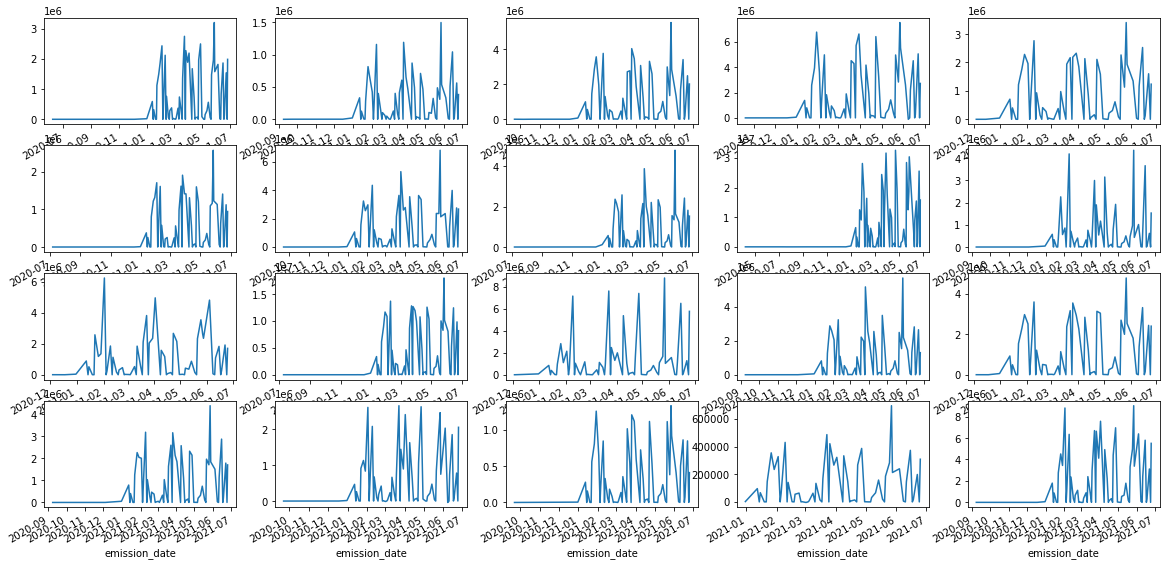

In [58]:
# light consumption region by region
nrow=4
ncol=5

df_list = [ light[light['Region'] == i] for i in light.Region.unique()]
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 10))

# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].set_index('emission_date')['light_consumption'].plot(ax=axes[r,c])
        count+=1

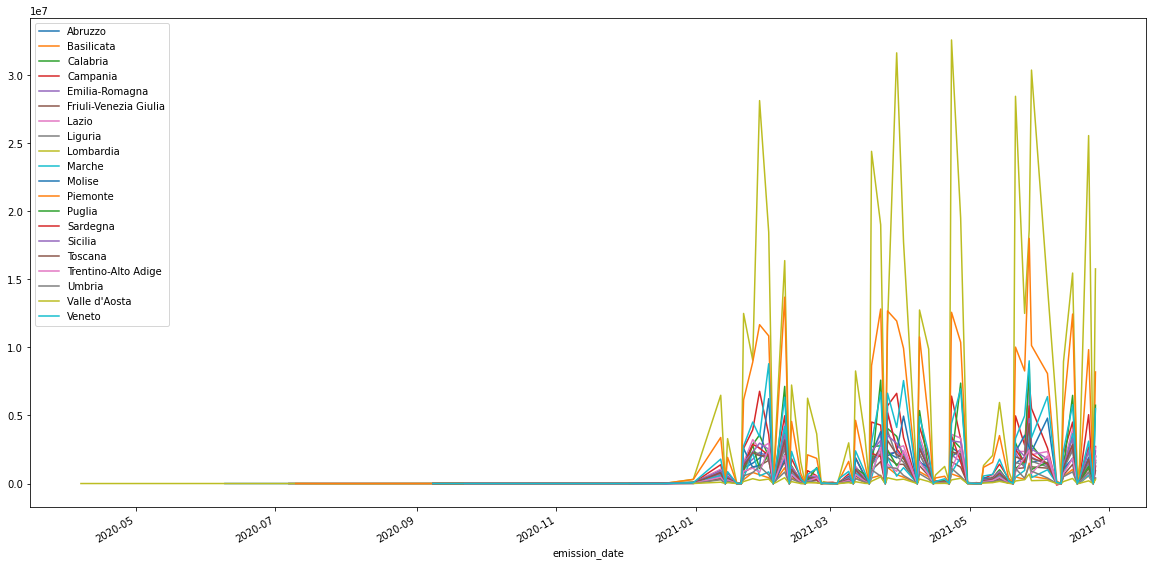

In [45]:
reg_list = light.set_index('emission_date').groupby('Region')['light_consumption'].plot( legend=True, figsize=(20, 10))

/opt/conda/envs/rapids/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: unhashable type: 'numpy.ndarray'

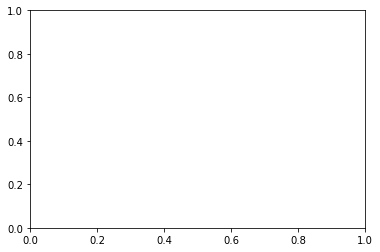

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(light.set_index('emission_date').groupby('Region')['light_consumption'])
ax.set_title('Simple plot')

In [23]:
light = light.reset_index()

In [27]:
light

,Region,emission_date,light_consumption
0,Abruzzo,2020-12-04,335.0
1,Abruzzo,2020-12-31,18770.0
2,Abruzzo,2021-01-12,588430.0
3,Abruzzo,2021-01-14,0.0
4,Abruzzo,2021-01-15,318375.0
...,...,...,...
1382,Toscana,2021-06-10,0.0
1383,Trentino-Alto Adige,2021-06-10,75.0
1384,Umbria,2021-06-10,589.0
1385,Valle d'Aosta,2021-06-10,0.0


AttributeError: 'Line2D' object has no property 'columns'

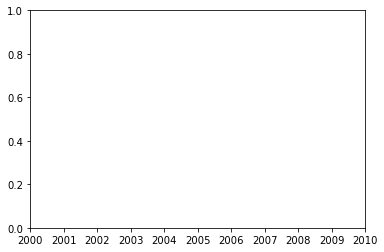

In [26]:
light.plot.line(x='emission_date', y='light_consumption')

### All the record with city == VIETRI DI POTENZA have address and nominative null and all the addresses and nominative null values are the VIETRI DI POTENZA records

In [ ]:
#esempio
base.locate_null_values('address').shape[0].compute()

In [ ]:
base[base['city'] == 'VIETRI DI POTENZA'].shape[0].compute()

In [ ]:
base[base['nominative'].isna()].shape[0].compute()

## Locate Missing Values DA PORTARE

In [47]:
# LOCATE MISSING VALUES
#rows = df.shape[0]
#wait(ddf.shape[0])
#print("Total rows", rows)
import json

# These are the colums with at least one missing value
column_count_nan = {}
# compute the presence of null value on time instead every iteration for performance reasons
na = base.get_df().isna()

res = na.sum().compute()
column_count_nan = json.loads(res.to_json())
column_count_nan

{'bill_id': 0,
 'F1_kWh': 166,
 'F2_kWh': 92,
 'F3_kWh': 689,
 'city': 15,
 'address': 2760,
 'nominative': 2760,
 'sex': 0,
 'age': 0,
 'user_code': 0,
 'date': 7871,
 'light_start_date': 7871,
 'light_end_date': 7871,
 'tv': 0,
 'gas_amount': 2244,
 'gas_average_cost': 602976,
 'light_average_cost': 281175,
 'emission_date': 0,
 'supply_type': 0,
 'gas_end_date': 7871,
 'gas_start_date': 7871,
 'extra_fees': 0,
 'gas_consumption': 2243,
 'light_consumption': 0,
 'gas_offer': 0,
 'light_offer_type': 0,
 'light_offer': 0,
 'howmuch_pay': 0,
 'total_amount': 0,
 'light_amount': 516,
 'average_unit_light_cost': 281126,
 'average_light_bill_cost': 280831,
 'average_unit_gas_cost': 602976,
 'average_gas_bill_cost': 601270,
 'customer_code': 0,
 'billing_frequency': 784810,
 'bill_type': 0,
 'gas_system_charges': 77977,
 'light_system_charges': 55353,
 'gas_material_cost': 70652,
 'light_transport_cost': 54526,
 'gas_transport_cost': 77265,
 'light_material_cost': 54533,
 'b_freq': 784810}

In [ ]:
# import json

# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super(NpEncoder, self).default(obj)
    
# with open('data/initial_null_val.json', 'w+') as f:
#     # this would place the entire output on one line
#     # use json.dump(lista_items, f, indent=4) to "pretty-print" with four spaces per indent
#     json.dump(column_count_nan, f, cls=NpEncoder, indent=2)

In [48]:
with open('data/initial_null_val.json', "r") as read_file:
    initial_column_count_nan = json.load(read_file)
initial_column_count_nan

{'bill_id': 0,
 'F1_kWh': 166,
 'F2_kWh': 92,
 'F3_kWh': 689,
 'city': 15,
 'address': 2760,
 'nominative': 2760,
 'sex': 0,
 'age': 0,
 'user_code': 0,
 'date': 7871,
 'light_start_date': 7871,
 'light_end_date': 7871,
 'tv': 0,
 'gas_amount': 3686754,
 'gas_average_cost': 4287486,
 'light_average_cost': 5967463,
 'emission_date': 0,
 'supply_type': 0,
 'gas_start_date': 7871,
 'gas_end_date': 7871,
 'extra_fees': 0,
 'gas_consumption': 3686753,
 'light_consumption': 5686817,
 'gas_offer': 0,
 'light_offer_type': 0,
 'light_offer': 0,
 'howmuch_pay': 0,
 'total_amount': 0,
 'light_amount': 5686804,
 'average_unit_light_cost': 5967414,
 'average_light_bill_cost': 5967119,
 'average_unit_gas_cost': 4287486,
 'average_gas_bill_cost': 4285780,
 'customer_code': 0,
 'billing_frequency': 784810,
 'bill_type': 0,
 'gas_system_charges': 3762487,
 'light_system_charges': 5741641,
 'gas_material_cost': 3755162,
 'light_transport_cost': 5740814,
 'gas_transport_cost': 3761775,
 'light_material_c

Differences between null value pre and post preprocessing

In [49]:
{k: initial_column_count_nan[k] - v for k,v in column_count_nan.items() if k in initial_column_count_nan}

{'bill_id': 0,
 'F1_kWh': 0,
 'F2_kWh': 0,
 'F3_kWh': 0,
 'city': 0,
 'address': 0,
 'nominative': 0,
 'sex': 0,
 'age': 0,
 'user_code': 0,
 'date': 0,
 'light_start_date': 0,
 'light_end_date': 0,
 'tv': 0,
 'gas_amount': 3684510,
 'gas_average_cost': 3684510,
 'light_average_cost': 5686288,
 'emission_date': 0,
 'supply_type': 0,
 'gas_end_date': 0,
 'gas_start_date': 0,
 'extra_fees': 0,
 'gas_consumption': 3684510,
 'light_consumption': 5686817,
 'gas_offer': 0,
 'light_offer_type': 0,
 'light_offer': 0,
 'howmuch_pay': 0,
 'total_amount': 0,
 'light_amount': 5686288,
 'average_unit_light_cost': 5686288,
 'average_light_bill_cost': 5686288,
 'average_unit_gas_cost': 3684510,
 'average_gas_bill_cost': 3684510,
 'customer_code': 0,
 'billing_frequency': 0,
 'bill_type': 0,
 'gas_system_charges': 3684510,
 'light_system_charges': 5686288,
 'gas_material_cost': 3684510,
 'light_transport_cost': 5686288,
 'gas_transport_cost': 3684510,
 'light_material_cost': 5686288}

In [ ]:
column_with_nan = []

perc = 80
soglia = ((perc * base.get_df().shape[0]) / 100).compute()
print(f'soglia {soglia}')

for c, val in column_count_nan.items():
    #print(f'{c}')
    if val > soglia:
        print(f'{c} val: {val}')
        column_with_nan.append(c)
        
column_with_nan

# Si può notare come nessuna colonna abbia il 100% di valori nulli, ma ci sono altresì tante 
# colonne con un numero elevato di nan. Poche colonne hanno un numero basso di nan.

### Analisi extra (utile estenderla all'intero dataset)

In [ ]:
#Visto che address e nominative hanno lo stesso numero di NA, vale la 
#pena controllare ed eventualmente eliminare le righe?

base.locate_null_values('nominative').shape[0].compute()

In [ ]:
base.locate_null_values('address').shape[0].compute()

In [ ]:
df[df['city'] == 'VIETRI DI POTENZA'].shape[0].compute()

Not all the user code are repeated, but even in the repeated we can't be sure if the 2 records correspond, this because the real name are hased and possible collission can exists

In [ ]:
df['user_code'].value_counts().shape[0].compute()

In [ ]:
# PROVO A VEDERE SE SONO PRESENTI ALTRI RECORDS DEGLI UTENTI A CUI MANCANO NOMINATIVE E ADDRESS
v = df['user_code'].value_counts()
v[v.gt(1)].index.compute()

In [ ]:
# DATASET CON GLI user_code CHE COMPAIONO PIù DI UNA VOLTA
df[df['user_code'].isin(v[v.gt(1)].index.compute())].compute()

In [ ]:
# Le date potrebbero fornirci informazioni sulla billing_frequency, o viceversa, come lo stabiliamo?
# Cosa indica la colonna dell'emission_date??

# NOTA PER DASK, SE FACCIAMO 0 CI TORNA IL PRIMO RECORD DI TUTTE LE 52 PARTIZIONI
df.loc[0, 'billing_frequency'].compute()

## Locate Outliers

In [ ]:
base['F1_kWh'].quantile(0.1).compute()

In [ ]:
#CERTE COLONNE CON IL TIPO DI DATO PARTICOLARE TIPO FLOATDTYPE64 VANNO CONVERTITE IN TIPI conformi 
base.locate_outliers('F1_kWh').head()

In [ ]:
type = df.dtypes
num = type[type!='object'][type!='bool']
num = num.index.to_list()
num

In [ ]:
tmp = ddf.locate_outliers("F1_kWh")
tmp = tmp.compute()
tmp.shape

In [ ]:
for col in num:
    tmp = base.locate_outliers(col)
    tmp = tmp.compute()
    
    print(f"{col} has {tmp.shape[0]} outliers")

## Sort Data

In [ ]:
base.sort("F1_kWh").head()

# 2. VALIDATION

In [ ]:
''' 
+++++ DATA VALIDATION +++++
    • Check data range
    • Check column uniqueness
    • Find data-mismatched data types
'''

## Check Data Range 

### Age nulla per PIVA

In [6]:
# set all the sex == P equals to NaN
base['age'] = base['age'].mask((base['sex']=='P'))
base[(base['sex']=='P')][['sex','age']].head()

,sex,age
5,P,NaN
23,P,NaN
64,P,NaN
67,P,NaN
71,P,NaN


### Age >= 18

In [65]:
# Age >= 18
# Age non ha valori nulli (già controllato in precedenza IN TEORIA)
# Dovrebbe corrispondere al numero di PIVA
print((~base['age'].isna()).sum().compute())
base[base['sex'] == 'P'].shape[0].compute()

10095931


401212

In [66]:
dataset_rows

10497143

In [56]:
# Che fare con i minorenni? Li mettiamo tutti a 18 anni?
base[base['age'] < 18].shape[0].compute()

415276

In [7]:
base['age'] = base['age'].mask(base['age'] < 18, 18)

In [58]:
base[base['age'] < 18].shape[0].compute()

0

### English Translation 

In [8]:
base['supply_type'].value_counts(dropna=False).compute()

gas              5686288
light            3684510
gas and light    1126345
Name: supply_type, dtype: int64

In [ ]:
# Dobbiamo metterli in inglese? Si può fare con un map
ing = {
    'luce': 'light',
    'gas e luce': 'gas and light',
    'gas' : 'gas',
}
base['supply_type'] = base['supply_type'].map(ing)

In [ ]:
base['supply_type'].value_counts(dropna=False).compute()

### Data control

### billing_freq & bill_type Analysis

In [14]:
# Billing frequency (‘monthly’, ‘quarterly’, etc.)
# Si potrebbero calcolare come differenza in termini di mesi tra lo start e l'end
base['billing_frequency'].value_counts(dropna=False).compute()

bimester     7611046
quarterly    1386049
NaN           784810
monthly       715238
Name: billing_frequency, dtype: int64

In [ ]:
# Kind of invoice (False means a “standard bill”)
base['bill_type'].value_counts(dropna=False).compute()

### light_offer_type Analysis

In [9]:
# Kind of plan for the electricity (‘single zone’, ‘bizone’, etc.)
base['light_offer_type'].value_counts(dropna=False).compute()

light                5712814
light single zone    4413764
ligth bizone          189594
light multi zones     180971
Name: light_offer_type, dtype: int64

In [10]:
# strip to all string columns
base['light_offer_type'] = base['light_offer_type'].str.strip()
base['light_offer_type'].value_counts(dropna=False).compute()

light                5712814
light single zone    4413764
ligth bizone          189594
light multi zones     180971
Name: light_offer_type, dtype: int64

## Check Column Uniqueness

In [ ]:
# The story changes here, we got these pairs as candidates as duplicate columns 
# (those which have same values for each row.)

# ATTENZIONE!! Probabile che le date del gas siano invertite, trovare un modo per confermarlo

In [64]:
# VERY time consuming, expecially with DASK, with DASK_CUDF It is a lot faster but It takes a lot of time as well
# base.get_duplicate_columns()
# Ne vengono individuate solo 5 di coppie 100% fedeli, 
# ma cambia la questione se abbassiamo la soglia? Ci sono degli errori sopra perchè 
# quelle 100% uguali non vengono riconosciute, mentre qua sì
duplicates = [('date', 'light_start_date'),('date', 'gas_end_date'),('light_start_date', 'gas_end_date'),('light_end_date', 'gas_start_date'),('gas_average_cost', 'average_unit_gas_cost')]
duplicates

[('date', 'light_start_date'),
 ('date', 'gas_end_date'),
 ('light_start_date', 'gas_end_date'),
 ('light_end_date', 'gas_start_date'),
 ('gas_average_cost', 'average_unit_gas_cost')]

## Find Data Mismatch

In [ ]:
base['date'] == base['light_start_date']

In [68]:
base[['light_start_date', 'light_end_date']][base['light_start_date'] <= base['light_end_date']].shape[0].compute()
# i record mancanti sono delle righe con le date null, ma di base vanno bene

10489272

In [66]:
10497143 

10497143

In [72]:
base[['gas_start_date', 'gas_end_date']][base['gas_start_date'] < base['gas_end_date']].shape[0].compute()
# da invertire

0

In [27]:
import datetime
(base['gas_end_date'].dt.month - base['gas_start_date'].dt.month).head()

0    7
1    0
2    0
3    2
4    0
dtype: int64

In [19]:
date_diff = ((base['gas_end_date'] - base['gas_start_date']) / np.timedelta64(1,'M')).round()
date_diff.tail()

542441    2.0
542442    2.0
542443    2.0
542444    8.0
542445    2.0
dtype: float64

C'è una corrispondenza tra billing frequency e star/end date di gas e luce perché 9M su 10 corrispondono. Quelle che non corrispondono si concentrano per la maggiorparte in un intorno di 0  

In [ ]:
val_count = (base['b_freq'] - date_diff).value_counts().compute()

In [37]:
val_count

 0.0      9064270
 1.0       311975
-2.0       137988
 2.0       111361
 3.0        55685
           ...   
-99.0           1
-58.0           1
-54.0           1
-51.0           1
-128.0          1
Length: 70, dtype: int64

<AxesSubplot:>

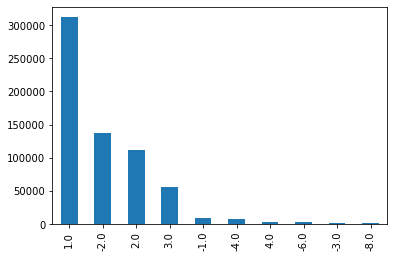

In [36]:
val_count[(val_count > 1000) & (val_count < 1000000)].plot(kind='bar')

In [15]:
base[['billing_frequency', 'gas_end_date', 'gas_start_date', 'emission_date']].tail()

,billing_frequency,gas_end_date,gas_start_date,emission_date
542441,bimester,2021-04-03,2021-06-11,2021-06-11
542442,bimester,2021-04-10,2021-06-11,2021-06-11
542443,bimester,2021-04-10,2021-06-06,2021-06-11
542444,bimester,2020-10-10,2021-06-07,2021-06-11
542445,bimester,2021-04-03,2021-06-05,2021-06-11


In [10]:
base['billing_frequency'].value_counts(dropna=False).compute()

bimester     7611046
quarterly    1386049
NaN           784810
monthly       715238
Name: billing_frequency, dtype: int64

In [59]:
base['tv'].value_counts().shape[0].compute()

267

In [42]:
# Substitute False with standard bill

base['bill_type'] = base['bill_type'].replace('False', 'standard bill')

In [43]:
base['bill_type'].value_counts().compute()

standard bill             10446508
variation note               30477
change note correction       19616
cancellation bill              542
Name: bill_type, dtype: int64

In [45]:
# Non c'è nessuna riga tutta nulla
base.dropna(how='all')

,bill_id,F1_kWh,F2_kWh,F3_kWh,city,address,nominative,sex,age,user_code,...,average_gas_bill_cost,customer_code,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost
0,0,0.0,0.0,0.0,CIPRESSA,C23B8FC235DF5479FB28D81E827A59B819BB0748,0298E5E66B5653CDAACADD156261A2A916A56C7E,F,81,63D286C61D20D76E9C9317BEB8644D5EE45134E4,...,NaN,5AE3987CBA311BCAADC6274D28A7FB14B13B53C3,None,False,-0.06,<NA>,0.06,<NA>,-0.2,<NA>
1,1,81.0,62.0,76.0,ROCCAVIVARA,CBE6B021F41D589269FBC724C131CBFC9905D950,FDAE2B1E0934BB76255A727CC9F3F00AA39982D9,M,38,8053C7982DE8A18746A8F9F0D1DC4B0C33CAC0FA,...,NaN,5F88D510670063B20E789E6453BC2F3FB0BB67F7,None,False,<NA>,9.15,<NA>,5.68,<NA>,23.13
2,2,0.0,0.0,0.0,VIDRACCO,BFAEB566B3BB78B9ABD4F86DB3A78BFD8489013B,FEBE7F29FB854C477AFA7073C70F0E6EA81C6B00,M,53,4F053D54B9F1B6FE565498E7FA726501FD8FDD18,...,NaN,D4B8928760E729127EB4EB532C86127325FBA468,None,False,1.24,<NA>,-10.13,<NA>,-7.13,<NA>
3,3,0.0,0.0,0.0,MEZZOLOMBARDO,CBD30C382C72ED4A3D9DC9D11C13C155930E7C66,9220A3E83BDCE622F70A1456C7898687FD3EDAC8,M,50,115C7D34A79C66AFCDB4EB65262595B197B0F861,...,1.08,BD4DEF66D7EF2D3D683D9C381D2359AD24B41D9C,None,False,-0.88,<NA>,23.68,<NA>,17.66,<NA>
4,4,0.0,0.0,0.0,PINETO,4D17C711CADED6C1E9BD459088B4B80F24575FE7,642C21354EF6017D13220517E2A25D4A0442D4C5,M,65,C7734B97A212004CEA25956D8FDFEF068CD2B8F6,...,0.86,C0622AFD22384A4B54CD1ACAF7D988B89853A5AC,None,False,14.71,<NA>,141.57,<NA>,63.59,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542441,2512812,0.0,0.0,0.0,CASALZUIGNO,FE1047ECA6069845A48B36ABAD2A725C545A3ACD,59801133A00E8156E2FCB182350344C222C625E9,M,66,CCC653F93977E0948C0E71592DC0B35D8088BF80,...,1.23,B90850838689F4530C6B2403ABF9D6A7DB4A6C18,bimester,False,-2.09,<NA>,41.72,<NA>,34.95,<NA>
542442,2512813,0.0,0.0,0.0,ACQUANEGRA CREMONESE,31432A91213A1877995BE91793761AB04AB2C1D9,ED3368875442BC333089F2EF36CEF71865954BCC,F,46,CEF01180CFC826BD1B1D940A77532A09A4E13761,...,1.29,6CCC81E05B7ED7401945CB8FB42126B242AB443C,bimester,False,-1.1,<NA>,41.64,<NA>,34.03,<NA>
542443,2512814,0.0,0.0,0.0,SAN LUPO,B3260B1FAEE19CB253D0B27B10CDCE0F40606AA4,959F1C15E6FD24DF29439A2B4683EC280BB95466,M,45,255D0B199EAAC6E72B483D38E4EA85C643109633,...,1.58,5DC1024A436D07BDF4C4853A752CF89775C3F295,bimester,False,-3.83,<NA>,30.81,<NA>,21.25,<NA>
542444,2512815,0.0,0.0,0.0,VERNATE,9AADECE289CFA1A60FAE6F30354B16DEEE1644A0,D3FD778C3F95AE2DAB5B9A1FE11FC14728D85164,M,64,A6E6C0A1A17CE15A4A822F516E5F6B1E8CD68B23,...,1.09,454279C1315FE7D78684138FB9998240B99D86DC,bimester,False,-0.22,<NA>,67.14,<NA>,27.61,<NA>


# 3. STRUCTURING

In [ ]:
''' 
+++++ DATA STRUCTURING +++++
    • Change column data types
    • Delete, split or merge columns
    • Pivot and unpivot
'''

## Change Column Data Types 

In [ ]:
# aggregabile con lo step precedente
# FATTO SOPRA

## Delete, split or merge columns

Da cancellare: 

- le date duplicate (start_gas/light con date, le trovi in colonne duplicate)
- gas costs

Da merge:
- F1,F2,F3 --> light consumption quindi in un'ipotetica riduzione di dati si possono eliminare

Da split:
- mese e anno di emission
- howmuch_pay = tv + total_amount, total_amount = light_amount + gas_amount + extra_fees. data l'indipendenza di tutte queste colonne possiamo tenere solo le singole colonne.

In [65]:
duplicates

[('date', 'light_start_date'),
 ('date', 'gas_end_date'),
 ('light_start_date', 'gas_end_date'),
 ('light_end_date', 'gas_start_date'),
 ('gas_average_cost', 'average_unit_gas_cost')]

## Pivot and unpivot

proposte di pivot:
- consumo/spesa complessiva delle città 
- anno/mese consumi
- qualcosa col bill_type/light_offer_type

In [ ]:
base['supply_type'] = base['supply_type'].astype('category')
base['supply_type'] = base['supply_type'].cat.as_known()
base['supply_type'].cat.known


In [11]:
a = base.pivot(index='sex', columns='supply_type', values='age', aggfunc='mean').compute()
a

supply_type,gas,gas and light,light
sex,,,
F,56.740326,56.234025,56.658268
M,56.081070,57.128664,56.096829
P,NaN,NaN,NaN


In [14]:
(base['city'] == 'FINALE EMILIA').sum().compute()

908

In [9]:
base[base['sex'] == 'P']['sex'].isna().sum().compute()

0

# 4. ENRICHMENT

In [ ]:
''' 
+++++ DATA ENRICHMENT +++++
    • Calculate columns using expressions
    • Set primary key column
    • Join or append DataFrames
    • Group by and aggregate records
    • Scale column values into a certain range
    • Encode categorical data (one-hot encoding and label encoding)
'''

In [6]:
comuni['Comune'] = comuni['Comune'].str.strip()
comuni['Comune'] = comuni['Comune'].str.translate(str.maketrans("ŠŽšžŸÀÁÂÃÄÅÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖÙÚÛÜÝàáâãäåçèéêëìíîïðñòóôõöùúûüýÿ", "SZszYAAAAAACEEEEIIIIDNOOOOOUUUUYaaaaaaceeeeiiiidnooooouuuuyy", "'")).str.upper()
comuni = comuni.set_index('Comune').to_dict()['Regione']

In [7]:
'SAINT-OYEN' in comuni

True

## Calculate Columns Using Expressions

In [ ]:
# F1 + F2 + F3 = tot consumption 
# end - start = billing frequency (month) 
# average cost = (circa) consumption / amount (light e gas)

# 5. FILTERING

In [ ]:
''' 
+++++ DATA FILTERING +++++
    • Sample rows
    • Select a subset of rows through a user-defined query
'''

## Set PK column

In [ ]:
# utility table --> customer code, user code
# costumer --> user code
# invoice --> bill id

### Utility

In [8]:
utility_cols = ['customer_code', 'user_code', 'city', 'address']
utility_df = base[utility_cols]

In [9]:
utility_df = utility_df.assign(pk=utility_df['customer_code'] + '_' + utility_df['user_code'])
utility_df = utility_df.set_index(utility_df.pk).drop(['pk'], axis=1)
utility_df = utility_df.drop_duplicates()
utility_df = utility_df.persist()

In [10]:
# utility_df.to_parquet('data/utility')

[None]

In [11]:
utility_df = dd.read_parquet('data/utility', blocksize="256MB")
utility_df.head()

,customer_code,user_code,city,address
pk,,,,
00000504EC20CF9CEF13A65EB878010295CD44EC_97F5F031B3076E9D214E494C8D8E98B2D731C6E4,00000504EC20CF9CEF13A65EB878010295CD44EC,97F5F031B3076E9D214E494C8D8E98B2D731C6E4,NUS,F89103F746DD449E5E7FEF4FA1B2F6ED24C90943
0000062C30D1D7C00963879E5A4EB90525059509_32B6DDC70758D03E2D2B05D0372E7BB6E1D7AC7C,0000062C30D1D7C00963879E5A4EB90525059509,32B6DDC70758D03E2D2B05D0372E7BB6E1D7AC7C,SALUGGIA,E42917E90DA4C2A2CC69A1C224B1715E4270F8BC
0000066A2C47826854947C3AF63E3BC158A033E2_1B9BEE9C535DFA3623DF329996B2C9E3790FAD92,0000066A2C47826854947C3AF63E3BC158A033E2,1B9BEE9C535DFA3623DF329996B2C9E3790FAD92,LESINA,127FEE5F5973E255BDA3A8DF6D41C35B13A01842
00000CB3CB53F89B50C54DE6229E1169E5C8C5B2_17B66C65F24009DFFD2CC89FB34C9EFFE5B6B68D,00000CB3CB53F89B50C54DE6229E1169E5C8C5B2,17B66C65F24009DFFD2CC89FB34C9EFFE5B6B68D,BOTRUGNO,67B69F899BD16AC02315334B544006420BC14189
00000DC89C0512D774759C0DAA390973B52AE0B7_B8AD5AF1BF5D33258EA62DB11EED9C53174AD30F,00000DC89C0512D774759C0DAA390973B52AE0B7,B8AD5AF1BF5D33258EA62DB11EED9C53174AD30F,ENTRACQUE,C8DA6D1DBE7CE71B1B217DC6CC55C7FC495BBB9A


#### Adding Region Column

In [12]:
utility_df['Region'] = utility_df['city'].str.strip().replace(to_replace="'", value='', regex=True).map(comuni)

In [13]:
utility_df['Region'].value_counts(dropna=False).compute()

Lombardia                1543056
Piemonte                  773946
Veneto                    385428
Campania                  330087
Puglia                    282474
Lazio                     204371
Sicilia                   187654
Calabria                  187597
Sardegna                  173316
Abruzzo                   148801
Liguria                   143168
Molise                    136261
Toscana                   122098
Emilia-Romagna            112035
Trentino-Alto Adige       110943
Friuli-Venezia Giulia      90072
Marche                     77500
Umbria                     52855
Basilicata                 37095
NaN                        34244
Valle d'Aosta              17778
Name: Region, dtype: int64

In [14]:
utility_df[utility_df['Region'].isna()].head()

,customer_code,user_code,city,address,Region
pk,,,,,
00012B9425EDCDE447C16A1EE6C5CC98EEA3DDA3_157C52002AFB73041A35083C18227D16DBEDCD71,00012B9425EDCDE447C16A1EE6C5CC98EEA3DDA3,157C52002AFB73041A35083C18227D16DBEDCD71,GORNATE-OLONA,6E77B15CDC7555567B48E5E43B4DA004A6780C72,NaN
0008F572C7756A88B213F60FB13808805DE2FA50_B33B9F1A47887DFE14135F2BECEF81EB839EB80D,0008F572C7756A88B213F60FB13808805DE2FA50,B33B9F1A47887DFE14135F2BECEF81EB839EB80D,PUEGNAGO SUL GARDA,2E7818E82EC2CECA54C96D38A7B0562421714533,NaN
000B8357FD7FD3ECF4EB2FFD071DC197DEB43686_7339757E59E91FE9C96D714369239D410AAD0773,000B8357FD7FD3ECF4EB2FFD071DC197DEB43686,7339757E59E91FE9C96D714369239D410AAD0773,RASUN ANTERSELVA,DBF15AB5FB3227C804C5C55921D57683DD0F1C96,NaN
000BF217DD810E6C1A2CC5D31964F7B4A21BEDC7_B4935DD7370F4EB9EC8C97640AC8E36D784CD426,000BF217DD810E6C1A2CC5D31964F7B4A21BEDC7,B4935DD7370F4EB9EC8C97640AC8E36D784CD426,SALORNO,4D990D0BDDDA3B1F088E5F167A11B99431572645,NaN
000F6AAB6F15B878039D00A0BA8FF9A552693390_79EF107CF5AE90E3018D1FE52C61DAE8576E1FA7,000F6AAB6F15B878039D00A0BA8FF9A552693390,79EF107CF5AE90E3018D1FE52C61DAE8576E1FA7,LIVO CO,F1255E17DBC26B35449B4A09B31CD05DF7FBC6B8,NaN


### Customer

In [15]:
customer_cols = ['user_code', 'nominative', 'age', 'sex']
customer_df = base[customer_cols]

In [16]:
customer_df = customer_df.drop_duplicates()
customer_df = customer_df.set_index(customer_df.user_code).drop(['user_code'], axis=1)
customer_df = customer_df.persist()

In [17]:
customer_df.head()['sex'].head()

user_code
000002CAFB3DB7477079AF19ACDC69D6826B49E4    F
00000C83D0FCC5947B3DD6B8E612FF25C76EDB97    M
00000D085C0E13D413D2E262D3DF85DF1383B580    M
00000EF262B1A6AE50213B6CC0685D2569897A0A    M
000010884C10C5613E326ED2FB2A163BC338E8CA    M
Name: sex, dtype: object

In [18]:
# customer_df.to_parquet('data/customer')

[None]

In [19]:
customer_df = dd.read_parquet('data/customer', blocksize="256MB")
customer_df.head()

,nominative,age,sex
user_code,,,
000002CAFB3DB7477079AF19ACDC69D6826B49E4,E428B773264ACE5B2D9C118FBC2E4AD8D820DD50,62,F
00000C83D0FCC5947B3DD6B8E612FF25C76EDB97,44B19389CE0E7453950E66FD71C7D11F1E433083,57,M
00000D085C0E13D413D2E262D3DF85DF1383B580,212FAA8342D9E70648150E9EEF20A0018772715F,64,M
00000EF262B1A6AE50213B6CC0685D2569897A0A,798635B57E835CA395A89D8CECCD847693B5AA07,51,M
000010884C10C5613E326ED2FB2A163BC338E8CA,CC21E5AD1B5B937AF771C51060F812744792BB2E,66,M


### Invoice

proporrei come pk il bill_id e emission_date

In [20]:
invoice_cols = ['bill_id','F1_kWh','F2_kWh','F3_kWh','date','light_start_date','light_end_date','tv','gas_amount','gas_average_cost','light_average_cost','emission_date','supply_type','gas_start_date','gas_end_date','extra_fees','gas_consumption','light_consumption','gas_offer','light_offer_type','light_offer','total_amount','howmuch_pay','light_amount','average_unit_light_cost','average_light_bill_cost','average_unit_gas_cost','average_gas_bill_cost','billing_frequency','bill_type','gas_system_charges','light_system_charges','gas_material_cost','light_transport_cost','gas_transport_cost','light_material_cost']
invoice_df = base[invoice_cols]

In [21]:
invoice_df = invoice_df.sort_values('bill_id')
invoice_df = invoice_df.persist()

In [22]:
invoice_df[invoice_df['bill_id'] == 0].compute()['emission_date']

0        2020-12-31
438310   2021-03-30
132299   2021-02-23
254769   2021-05-27
384321   2021-01-26
467066   2021-04-27
Name: emission_date, dtype: datetime64[ns]

In [23]:
(invoice_df['bill_id'].astype(str) + '-' + invoice_df['emission_date'].dt.strftime('%d-%m-%Y')).head()

0         0-31-12-2020
438310    0-30-03-2021
132299    0-23-02-2021
254769    0-27-05-2021
384321    0-26-01-2021
dtype: object

In [24]:
invoice_df = invoice_df.set_index(invoice_df['bill_id'].astype(str) + '-' + invoice_df['emission_date'].dt.strftime('%d-%m-%Y'))
# invoice_df = invoice_df.drop_duplicates()
invoice_df = invoice_df.persist()

In [25]:
invoice_df.shape[0].compute()

10497143

In [26]:
invoice_df = invoice_df.drop_duplicates()
invoice_df.shape[0].compute()

10497143

In [27]:
# invoice_df.to_parquet('data/invoice')

[None]

In [28]:
invoice_df = dd.read_parquet('data/invoice', blocksize="256MB")
invoice_df.head()

,bill_id,F1_kWh,F2_kWh,F3_kWh,date,light_start_date,light_end_date,tv,gas_amount,gas_average_cost,...,average_unit_gas_cost,average_gas_bill_cost,billing_frequency,bill_type,gas_system_charges,light_system_charges,gas_material_cost,light_transport_cost,gas_transport_cost,light_material_cost
0-23-02-2021,0,14.0,20.0,46.0,2020-12-19,2020-12-19,2021-02-23,0.0,0.00,0.0,...,0.0,0.0,bimester,standard bill,0.00,3.34,0.00,14.74,0.00,18.72
0-26-01-2021,0,0.0,0.0,0.0,2020-12-31,2020-12-31,2020-12-31,0.0,0.00,0.0,...,0.0,0.0,None,standard bill,0.00,NaN,0.00,-10.42,0.00,NaN
0-27-04-2021,0,0.0,0.0,0.0,2021-03-31,2021-03-31,2021-03-31,0.0,0.00,0.0,...,0.0,0.0,None,standard bill,0.00,NaN,0.00,NaN,0.00,NaN
0-27-05-2021,0,0.0,1.0,1.0,2021-03-24,2021-03-24,2021-05-27,18.0,0.00,0.0,...,0.0,0.0,bimester,standard bill,0.00,0.08,0.00,14.06,0.00,12.13
0-30-03-2021,0,0.0,0.0,0.0,2021-02-03,2021-02-03,2021-03-30,0.0,11.49,NaN,...,NaN,NaN,bimester,standard bill,-2.26,0.00,6.24,0.00,5.53,0.00


# 6. CLEANING

In [ ]:
''' 
+++++ DATA CLEANING +++++
    • Change data format and case
    • Deduplicate data
    • Missing value imputation
    • Find and replace values
'''

# Table Analysis

## Invoices Analysis

In [55]:
invoice_df = invoice_df.assign(MONTH_em = invoice_df['emission_date'].dt.month)
invoice_df = invoice_df.assign(YEAR_em = invoice_df['emission_date'].dt.year)
invoice_df['MONTH_em'].head()

0-23-02-2021    2
0-26-01-2021    1
0-27-04-2021    4
0-27-05-2021    5
0-30-03-2021    3
Name: MONTH_em, dtype: int64

In [59]:
invoice_df.groupby(by=['YEAR_em', 'MONTH_em'])[['light_consumption', 'gas_consumption']].mean().compute()

light_consumption  gas_consumption
YEAR_em MONTH_em                                    
2020    4                  0.000000         0.000000
        6               -170.000000         0.000000
        7              -1611.000000       -15.800000
        8              -9731.000000       -10.393000
        9               -191.368421       -36.143278
        10              -498.125000       -83.000000
        11              -135.500000        -3.500000
        12                88.906090        22.793108
2021    1                276.313795       105.702065
        2                235.730509       195.058128
        3                134.053866       127.719031
        4                146.617909       131.070401
        5                213.201548        48.989545
        6                160.394023        51.483361

In [60]:
invoice_df.groupby(by=['YEAR_em', 'MONTH_em'])[['total_amount']].mean().compute()

total_amount
YEAR_em MONTH_em              
2020    4           133.938000
        6            49.260000
        7           685.914000
        8          9146.410000
        9           246.109474
        10          225.375000
        11           70.925000
        12           68.703756
2021    1           170.004437
        2           233.496984
        3           180.298055
        4           161.237124
        5           120.577353
        6           107.182779

## Customer Analysis

Age Categorizing 

In [4]:
bins = [0, 18, 35, 65, np.inf]
names = ['<8', '18-35', '35-65', '65+']
customer_df['age'] = customer_df['age'].map_partitions(pd.cut, bins, labels=names, meta='category')

In [5]:
customer_df.head()

,nominative,age,sex
user_code,,,
000002CAFB3DB7477079AF19ACDC69D6826B49E4,E428B773264ACE5B2D9C118FBC2E4AD8D820DD50,35-65,F
00000C83D0FCC5947B3DD6B8E612FF25C76EDB97,44B19389CE0E7453950E66FD71C7D11F1E433083,35-65,M
00000D085C0E13D413D2E262D3DF85DF1383B580,212FAA8342D9E70648150E9EEF20A0018772715F,35-65,M
00000EF262B1A6AE50213B6CC0685D2569897A0A,798635B57E835CA395A89D8CECCD847693B5AA07,35-65,M
000010884C10C5613E326ED2FB2A163BC338E8CA,CC21E5AD1B5B937AF771C51060F812744792BB2E,65+,M


In [23]:
nominative = customer_df['nominative'].value_counts() 
nominative[nominative > 1].shape[0].compute()

457455

In [4]:
distict = customer_df.groupby(by='nominative').sex.nunique()
distict.head()

nominative
00000250B284561D278A8DA7A549C3E5E11DA3CE    1
00001264E1715AC87C5DAEDE0C1ED7EFAF4F82C2    1
0000189D63F9CFAB8F526BB78FA3000264EE28A9    1
00002377B1A4FB18B82D9D1A5E90BE0A37833DCF    1
0000248792E36C35DDD7C0A6A32BADEA529AD418    1
Name: sex, dtype: int64

In [6]:
distict[distict > 1]

nominative
0003582AB7F0444AAD43C0BDF812B974B2B20816    2
001230D06477A6AE6D6D36752DD948E24A9DA175    2
0023AFA534F07CA71A46E5DE85A89C00F0E0FA5D    2
002BE2CD45606C1F3776229138E44C171BC507A2    2
003B394141E4610121EC1DEF935847A3041861E8    2
                                           ..
FFB4BFC6B06867CAF5341E6A7D5B4A390529F8BC    2
FFB56A78855AED350C97CA6B05C88E441FB97FB0    2
FFC63A448A427A9FAFDACE8377BC16B401EB6124    2
FFD193C9CB6CA114BDA207812A93C1B8EF2C5F72    2
FFD2063BF3E8401B0F2AEDBEDA150D8BDDF53893    2
Name: sex, Length: 5168, dtype: int64

Esistono nominativi con 2 sessi diversi 

In [14]:
customer_df[customer_df['nominative'].isin(distict.index)]['sex']

user_code
000002CAFB3DB7477079AF19ACDC69D6826B49E4    F
00000C83D0FCC5947B3DD6B8E612FF25C76EDB97    M
00000D085C0E13D413D2E262D3DF85DF1383B580    M
00000EF262B1A6AE50213B6CC0685D2569897A0A    M
000010884C10C5613E326ED2FB2A163BC338E8CA    M
                                           ..
FFFFF51CFB5F9F0158E10948C5029A82E5673FEF    M
FFFFF59035840C2E183A1CAB64A628D8279DE152    F
FFFFF808F44C503AE932F59F269201409453F812    M
FFFFFB574FFE983350DABEEBF8E55A973173D016    F
FFFFFB8C8BFC91DDE6F390EE5FF11EB72AF66E7A    F
Name: sex, Length: 4027409, dtype: object

## Brainstorming

In [ ]:
#Qui potremmo usare tipo un comando per eseguire una query (func. query in base.py) sul df 
#(ritorna quanto spendono le PIVA)

In [ ]:
# CHANGE DATA FORMAT AND CASE
# change data format già fatto sopra
# case pure se vogliamo aver fatto tutto per bene (dove è da fare?)

In [ ]:
# DEDUPLICATE DATA
# controllo se ho più bollette uguali dello stesso cliente
# lo abbiamo iniziato a fare anche questo sopra, credo basti

In [ ]:
# MISSING VALUE IMPUTATION
# qua fornirei solo delle possibilità su come trattare i NaN a seconda delle colonne (tipo in billing_frequency,
# eventuali Nan potrebbero essere calcolati facendo end_date - start_date)

In [ ]:
# FIND AND REPLACE VALUES
# farei finta di niente, non mi viene in mente nulla